## 0. Setup and Imports

In [34]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import ccxt
from curl_cffi import requests


## 1. Data Access / Cleaning

In [35]:
TICKER = 'AAPL'
# TICKER = 'BTC/USDT'
START_DATE = '2023-06-1'
END_DATE = '2025-05-7'
# START_TEST = '2025-01-01'
# END_TEST = '2025-05-7'
INTERVAL = '1h'
FREQ = 'H'
LAGS = [1, 2, 3, 5]
ROLL_WINDOW = 5

# =====================
# === Доступ до даних ===
# =====================
from curl_cffi import requests

def download_data(ticker: str, start: str, end: str, interval: str) -> pd.DataFrame:
    session = requests.Session(impersonate="chrome")
    # ticker = yf.Ticker('...', session=session)
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=True, session=session)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.index = pd.to_datetime(df.index)
    return df

# def download_data(ticker: str, start_date: str, end_date: str, timeframe: str) -> pd.DataFrame:
#     exchange = ccxt.binance()  # Замість 'binance' можна вказати іншу біржу
#     since = exchange.parse8601(f'{start_date}T00:00:00Z')
    
#     ohlcv = exchange.fetch_ohlcv(ticker, timeframe, since, limit=1000)  # Можна налаштувати limit
#     df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
#     df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
#     df.set_index('timestamp', inplace=True)
    
#     # Перейменовуємо стовпці для відповідності з іншими функціями
#     df.rename(columns={
#         'open': 'Open',
#         'high': 'High',
#         'low': 'Low',
#         'close': 'Close',
#         'volume': 'Volume'
#     }, inplace=True)
    
    # Фільтруємо дані до дати закінчення
    df = df[df.index <= pd.to_datetime(end_date)]
    
    return df


# =====================
# === Очищення ===
# =====================

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    # Вирівнювання частоти
    df = df.asfreq(FREQ)
    # Інтерполяція
    df = df.interpolate(method='time')
    # Видалення викидів
    num = df.select_dtypes(include=[np.number])
    z = np.abs((num - num.mean()) / num.std())
    df = df[(z < 3.0).all(axis=1)]
    return df

# =====================
# === Індикатори ===
# =====================

def SMA(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window).mean()

def EMA(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def bollinger(series: pd.Series, window: int, num_std: int):
    m = SMA(series, window)
    s = series.rolling(window).std()
    return m + num_std * s, m - num_std * s

def RSI(series: pd.Series, window: int) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))


def ATR(df: pd.DataFrame, window: int) -> pd.Series:
    hl = df['High'] - df['Low']
    hc = (df['High'] - df['Close'].shift()).abs()
    lc = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    return tr.rolling(window).mean()

# =====================
# === Створення ознак ===
# =====================

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    feats = pd.DataFrame(index=df.index)
    # Додати базові стовпці OHLCV
    feats[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    # Технічні індикатори
    feats['SMA20'] = SMA(df['Close'], 20)
    feats['EMA20'] = EMA(df['Close'], 20)
    up, low = bollinger(df['Close'], 20, 2)
    feats['BB_up'], feats['BB_low'] = up, low
    feats['RSI'] = RSI(df['Close'], 14)
    feats['ATR'] = ATR(df, 14)
    # Лаг-ознаки
    for lag in LAGS:
        feats[f'lag_{lag}'] = df['Close'].shift(lag)
    # Ковзні статистики
    ret = df['Close'].pct_change()
    feats['ret_mean'] = ret.rolling(ROLL_WINDOW).mean()
    feats['ret_std'] = ret.rolling(ROLL_WINDOW).std()
    feats = feats.dropna()
    return feats

# =====================
# === Підготовка X та y ===
# =====================

def prepare_xy(df):
    X = create_features(df)
    y = df.loc[X.index, 'Close']
    return X, y

# =====================
# === Головна функція ===
# =====================


raw = download_data(TICKER, START_DATE, END_DATE, INTERVAL)
clean = clean_data(raw)
X, y = prepare_xy(clean)
print(f"Готово: X.shape={X.shape}, y.shape={y.shape}")


[*********************100%***********************]  1 of 1 completed

Готово: X.shape=(16591, 17), y.shape=(16591, 1)



C:\Users\b.yarinko\AppData\Local\Temp\ipykernel_26360\3182105457.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(FREQ)


## 2. Pre-trade Analysis 

           mean       std      skew    kurtosis       min       max
Close  0.000008  0.001969  0.355796  173.096248 -0.056547  0.054767


C:\Users\b.yarinko\AppData\Local\Temp\ipykernel_26360\1183978534.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c')


       adf_stat  adf_pvalue  kpss_stat  kpss_pvalue
Close -1.793699    0.383594  14.617905         0.01


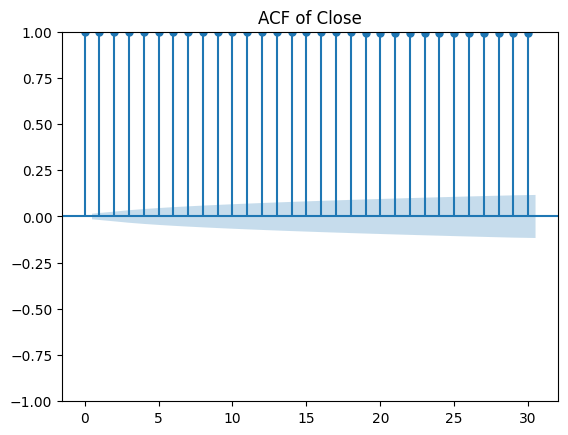

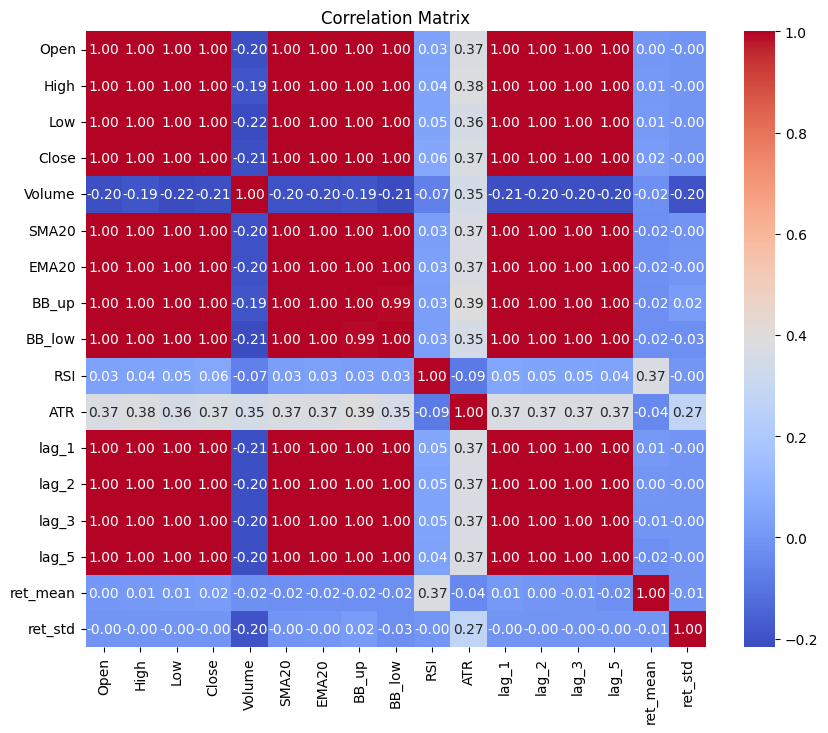

                                    PC1        PC2        PC3
Datetime                                                     
2023-06-02 08:30:00+00:00  6.139711e+06 -54.993461   9.447667
2023-06-02 09:30:00+00:00  6.689751e+06 -53.497882 -44.809392
2023-06-02 10:30:00+00:00  7.239792e+06 -51.171713 -44.486105
2023-06-02 11:30:00+00:00  7.789833e+06 -48.860960 -44.162056
2023-06-02 12:30:00+00:00  8.339874e+06 -46.543874 -43.838339


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA
import seaborn as sns

# =====================
# === Етап 2: Pre-trade Analysis ===
# =====================

# 1. Непараметричні статистики доходностей
# -----------------------------------------
def compute_return_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Обчислює базові статистики доходностей для кожного стовпця в df
    """
    ret = df.pct_change().dropna()
    stats = pd.DataFrame(index=ret.columns)
    stats['mean'] = ret.mean()
    stats['std'] = ret.std()
    stats['skew'] = skew(ret)
    stats['kurtosis'] = kurtosis(ret)
    stats['min'] = ret.min()
    stats['max'] = ret.max()
    return stats

# 2. Тести на stationarity
# ------------------------

def stationarity_tests(series: pd.Series) -> dict:
    """
    Виконує ADF та KPSS тести для серії
    """
    adf_res = adfuller(series.dropna(), autolag='AIC')
    kpss_res = kpss(series.dropna(), regression='c')
    return {
        'adf_stat': adf_res[0], 'adf_pvalue': adf_res[1],
        'kpss_stat': kpss_res[0], 'kpss_pvalue': kpss_res[1]
    }

def run_stationarity(df):
    """
    Виконує ADF та KPSS тести для кожного стовпця DataFrame або для Series
    """
    results = {}
    if isinstance(df, pd.Series):
        # Однозмінний випадок
        res = stationarity_tests(df)
        return pd.DataFrame([res], index=[df.name])
    for col in df.columns:
        results[col] = stationarity_tests(df[col])
    return pd.DataFrame(results).T

# 3. Автокореляція
# ----------------
def plot_autocorrelation(series: pd.Series, lags: int = 20):
    """
    Будує автокореляційну функцію up to lags
    """
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(series.dropna(), lags=lags)
    plt.title(f'ACF of {series.name}')
    plt.show()

# 4. Кореляційна структура та heatmap
# -----------------------------------
def plot_correlation_heatmap(df: pd.DataFrame):
    corr = df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# 5. PCA та кластеризація
# -----------------------
def pca_and_cluster(df: pd.DataFrame, n_components: int = 3) -> pd.DataFrame:
    """
    Виконує PCA та повертає компоненти. Якщо n_components більше за число ознак, автоматично коригується.
    """
    df_clean = df.dropna()
    n_feats = df_clean.shape[1]
    n_samps = df_clean.shape[0]
    # Коригуємо n_components за наявними даними
    k = min(n_components, n_feats, n_samps)
    if k < 1:
        raise ValueError(f"PCA не може бути виконано: доступних ознак {n_feats}, зразків {n_samps}")
    pca = PCA(n_components=k)
    comps = pca.fit_transform(df_clean)
    cols = [f'PC{i+1}' for i in range(k)]
    return pd.DataFrame(comps, index=df_clean.index, columns=cols)

# -------------------------
# === Приклад використання ===
# -------------------------

stats = compute_return_stats(X[['Close']])
print(stats)
# 2. Stationarity
st = run_stationarity(X['Close'])
print(st)
# 3. ACF plot
plot_autocorrelation(X['Close'], lags=30)
# 4. Correlation heatmap
plot_correlation_heatmap(X)
# 5. PCA
# pc_df = pca_and_cluster(X[['Close']])
pc_df = pca_and_cluster(X)
print(pc_df.head())


## Етап 3. Alpha-модель (торговий сигнал)

1. **Вибір підходу**

   * **Класичний**: лінійна регресія / LASSO / Ridge з відбором індикаторів.
   * **ML**: RandomForest / XGBoost з оптимізацією гіперпараметрів.
   * **DL**: одношаровий LSTM або Temporal Convolutional Network (TCN).
2. **Розбиття на train/validation/test**

   * Walk-forward validation (скользячий віконний).
3. **Навчання й оптимізація**

   * GridSearchCV або Bayesian оптимізація.
   * Метрики: Sharpe ratio прогнозу, accuracy напрямку, MSE.
4. **Формули**

   * Регресійна модель:

     $$
       \hat y_t = \beta_0 + \sum_i \beta_i x_{i,t}
     $$
   * Дерева рішень: формули impurity, split criteria.
   * LSTM cell:

     $$
       f_t = \sigma(W_f [h_{t-1}, x_t] + b_f), \quad \ldots
     $$


In [37]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input

# =====================
# === Етап 3: Alpha-модель (класифікація напрямку) ===
# =====================

# --- 0. Підготовка даних: X та сигнали ---

def generate_signals(X, y, threshold=0.005):
    # Get price data as Series if it's a DataFrame
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]  # Take the first column
    
    # Calculate percentage price change
    pct_change = y.pct_change(-1, fill_method=None).dropna()  # Next day relative to current day

    # Create signals with threshold
    signals = np.ones(len(pct_change))  # Initialize with 1 (HOLD)
    signals[pct_change < -threshold] = 0    # Significant decrease -> SELL (0)
    signals[pct_change > threshold] = 2     # Significant increase -> BUY (2)

    # Cast to int for classification
    signals = signals.astype(int)

    # Create signals series with proper index
    signals = pd.Series(signals, index=pct_change.index, name='signal')

    # Align X and signals to the intersection of their indices
    common_idx = X.index.intersection(signals.index)
    X_processed = X.loc[common_idx].copy()
    signals = signals.loc[common_idx]

    return X_processed, signals

# --- 1. Walk-forward split ---

def walk_forward_indices(n_samples: int, n_splits: int):
    test_size = n_samples // (n_splits + 1)
    indices = []
    for i in range(n_splits):
        train_end = test_size * (i + 1)
        test_start = train_end
        test_end = test_size * (i + 2)
        indices.append(((0, train_end), (test_start, min(test_end, n_samples))))
    return indices

# --- 2. XGBoost Classifier with walk-forward ---

def train_xgb(X: pd.DataFrame, y: pd.Series, splits, param_grid):
    best_params, best_score = None, 0
    for params in ParameterGrid(param_grid):
        scores = []
        for tr, te in splits:
            X_tr, X_te = X.iloc[tr[0]:tr[1]], X.iloc[te[0]:te[1]]
            y_tr, y_te = y.iloc[tr[0]:tr[1]], y.iloc[te[0]:te[1]]
            # масштабування
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)
            model = XGBClassifier(**params, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
            model.fit(X_tr_s, y_tr)
            preds = model.predict(X_te_s)
            scores.append(accuracy_score(y_te, preds))
        avg = np.mean(scores)
        if avg > best_score:
            best_score, best_params = avg, params
    # фінальна модель на всіх даних
    scaler_full = StandardScaler().fit(X)
    X_full_s = scaler_full.transform(X)
    final_model = XGBClassifier(**best_params, eval_metric='logloss')
    final_model.fit(X_full_s, y)
    return final_model, scaler_full, best_params, best_score

# --- 3. LSTM Classifier with walk-forward ---

def build_lstm(input_shape, units=128, drop=0.4, n_layers=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for i in range(n_layers - 1):
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(drop))
    model.add(LSTM(units))
    model.add(Dropout(drop))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(drop / 2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 класи: SELL, HOLD, BUY
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def train_lstm(X: pd.DataFrame, y: pd.Series, splits, epochs=50, batch_size=32):
    histories = []
    scalers = []
    for tr, te in splits:
        X_tr, X_te = X.iloc[tr[0]:tr[1]], X.iloc[te[0]:te[1]]
        y_tr, y_te = y.iloc[tr[0]:tr[1]], y.iloc[te[0]:te[1]]
        # масштабування
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)
        # reshape для LSTM
        X_tr_s = X_tr_s.reshape(-1, X_tr_s.shape[1], 1)
        X_te_s = X_te_s.reshape(-1, X_te_s.shape[1], 1)
        model = build_lstm((X_tr_s.shape[1], 1))
        es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        history = model.fit(X_tr_s, y_tr, epochs=epochs, batch_size=batch_size,
                            verbose=0, callbacks=[es])
        histories.append(history)
        scalers.append(scaler)
    # тренуємо останню модель на всіх даних
    # використовуємо останній scaler
    X_all_s = scalers[-1].transform(X).reshape(-1, X.shape[1], 1)
    final_model = build_lstm((X.shape[1], 1))
    final_model.fit(X_all_s, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return final_model, scalers[-1], histories

# =====================
# === Виконання ===
# =====================



In [38]:
X_signal, y_signal = generate_signals(X, y, threshold=0.005)
test_size = int(0.2 * len(X_signal))
X_train, y_train = X_signal[:-test_size], y_signal[:-test_size]
X_test, y_test = X_signal[-test_size:], y_signal[-test_size:]
splits = walk_forward_indices(len(X_train), n_splits=5)
print("Signal counts:\n", y_train.value_counts())

Signal counts:
 signal
1    13022
2      137
0      113
Name: count, dtype: int64


In [39]:
# LSTM
lstm_mod, lstm_scaler, lstm_hist = train_lstm(X_train, y_train, splits)
# # Оцінка на останньому спліті
tr, te = splits[-1]
X_te = X_train.iloc[te[0]:te[1]]
y_te = y_train.iloc[te[0]:te[1]]
X_te_s = lstm_scaler.transform(X_te).reshape(-1, X_train.shape[1], 1)
# Get class predictions for each sample
lstm_probs = lstm_mod.predict(X_te_s)
lstm_preds = np.argmax(lstm_probs, axis=1)
print('LSTM Acc:', accuracy_score(y_te, lstm_preds))

# XGBoost
param_grid = {'n_estimators': [300], 'max_depth': [1], 'learning_rate': [0.01]}
xgb_mod, xgb_scaler, xgb_params, xgb_score = train_xgb(X_train, y_train, splits, param_grid)
print('XGB best params:', xgb_params, 'WF Acc:', xgb_score)
# Оцінка XGBoost на останньому спліті
X_te_s = xgb_scaler.transform(X_te)
xgb_preds = xgb_mod.predict(X_te_s)
print('XGB Acc:', accuracy_score(y_te, xgb_preds))


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
LSTM Acc: 0.9868896925858951
XGB best params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 300} WF Acc: 0.9802893309222422
XGB Acc: 0.9868896925858951


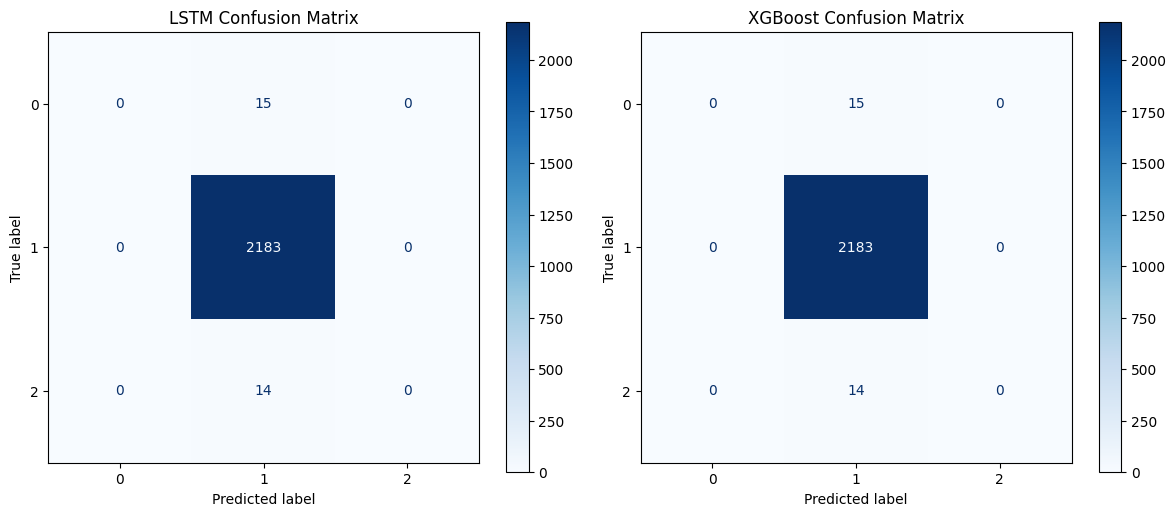

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# LSTM confusion matrix
cm_lstm = confusion_matrix(y_te, lstm_preds)
disp_lstm = ConfusionMatrixDisplay(cm_lstm)
disp_lstm.plot(cmap='Blues', ax=axes[0]) # Plot on the first subplot
axes[0].set_title('LSTM Confusion Matrix')

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_te, xgb_preds)
disp_xgb = ConfusionMatrixDisplay(cm_xgb)
disp_xgb.plot(cmap='Blues', ax=axes[1]) # Plot on the second subplot
axes[1].set_title('XGBoost Confusion Matrix')

plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()


## Етап 4. Модель оцінки ризиків

1. **Оцінка волатильності**

   * GARCH(1,1) для прогнозу σ²ₜ:

     $$
       σ_t^2 = ω + α ε_{t-1}^2 + β σ_{t-1}^2
     $$
2. **Кореляційна структура портфеля**

   * Shrinkage-оцінка коваріаційної матриці (Ledoit–Wolf).
3. **VaR / CVaR**

   * Історичний VaR, параметричний (нормальний розподіл).
4. **Розрахунок погрозливості позицій**

   * Position sizing за правилом Kelly або Risk parity.

In [48]:
from arch import arch_model
from sklearn.covariance import LedoitWolf
from scipy.stats import norm
from scipy.special import erfinv
import pandas as pd
import numpy as np

def fit_garch(series: pd.Series):
    """
    Підганяє GARCH(1,1) модель до доходностей series, повертає прогноз дисперсії
    """
    ret = series.dropna() * 100  # масштабування для стабільності
    am = arch_model(ret, vol='Garch', p=1, q=1, dist='normal')
    res = am.fit(disp='off')
    # прогноз волатильності на наступний період
    forecast = res.forecast(horizon=1)
    var_forecast = forecast.variance.iloc[-1, 0] / (100**2)
    return var_forecast, res.params


def shrinkage_covariance(returns: pd.DataFrame):
    """
    Оцінює коваріаційну матрицю з застосуванням Ledoit-Wolf shrinkage
    """
    lw = LedoitWolf().fit(returns.dropna()) # Ensure NaNs are handled
    return pd.DataFrame(lw.covariance_, index=returns.columns, columns=returns.columns)


def compute_var_cvar(returns: pd.Series, alpha: float = 0.05):
    """
    Обчислює історичний та параметричний VaR і CVaR на рівні alpha
    """
    ret = returns.dropna()
    if ret.empty:
        return {
            'VaR_historical': np.nan,
            'CVaR_historical': np.nan,
            'VaR_parametric': np.nan,
            'CVaR_parametric': np.nan
        }
    # Historical VaR
    var_hist = -np.quantile(ret, alpha)
    cvar_hist = -ret[ret <= np.quantile(ret, alpha)].mean()
    # Parametric (normal)
    mu, sigma = ret.mean(), ret.std()
    # Handle cases where sigma might be zero or NaN
    if sigma == 0 or np.isnan(sigma):
        var_param = -mu
        cvar_param = -mu
    else:
        norm_ppf_alpha = norm.ppf(alpha)
        var_param = -(mu + sigma * norm_ppf_alpha)
        cvar_param = -(mu - sigma * norm.pdf(norm_ppf_alpha) / alpha)
    return {
        'VaR_historical': var_hist,
        'CVaR_historical': cvar_hist,
        'VaR_parametric': var_param,
        'CVaR_parametric': cvar_param
    }


def kelly_allocation(returns: pd.Series):
    """
    Обчислює Келлі-оптимальні ваги для одного активу: w = mu/var
    """
    mu = returns.mean()
    var = returns.var()
    if var == 0 or np.isnan(var): # Avoid division by zero
        return np.nan
    return mu / var


def risk_parity_weights(cov_matrix: pd.DataFrame):
    """
    Простий ризик-паритет: ваги пропорційні зворотньому волатильності
    """
    vol = np.sqrt(np.diag(cov_matrix))
    # Handle zero volatility
    if np.any(vol == 0):
        # Assign zero weight to assets with zero volatility, distribute rest
        non_zero_vol_indices = np.where(vol != 0)[0]
        if len(non_zero_vol_indices) == 0:
             # If all have zero vol, return equal weights (or handle as error)
             return pd.Series(1/len(vol) if len(vol) > 0 else 0, index=cov_matrix.index)
        inv_vol = np.zeros_like(vol)
        inv_vol[non_zero_vol_indices] = 1 / vol[non_zero_vol_indices]
    else:
        inv_vol = 1 / vol
    w = inv_vol / np.sum(inv_vol)
    return pd.Series(w, index=cov_matrix.index)

# ---------- Приклад використання ----------

if isinstance(y, pd.DataFrame):
    # Якщо y - DataFrame, беремо стовпець 'Close' або перший стовпець
    if 'Close' in y.columns:
        prices = y['Close']
        price_series_name = 'Close'
    elif not y.empty:
         prices = y.iloc[:, 0]
         price_series_name = y.columns[0]
    else:
        # Якщо DataFrame порожній, створити порожню Series, щоб уникнути помилок далі
        # Або краще викликати помилку, якщо дані необхідні
        raise ValueError("DataFrame 'y' порожній.")
elif isinstance(y, pd.Series):
    prices = y
    price_series_name = y.name if y.name else 'Price'
else:
    raise TypeError("Змінна 'y' не є ні DataFrame, ні Series.")

# Розраховуємо доходності - припускаємо, що prices має достатньо даних
returns = prices.pct_change().dropna()
if returns.empty:
    raise ValueError("Не вдалося розрахувати доходності (недостатньо даних).")


# 1. GARCH
var_forecast, params = fit_garch(returns)
print('GARCH σ² forecast:', var_forecast)
print('GARCH Params:', params)

# 2. Shrinkage cov
returns_df = returns.to_frame(name=price_series_name)
if returns_df.shape[0] <= 1:
    raise ValueError("Shrinkage Covariance: Недостатньо даних (потрібно > 1).")
cov_shrunk = shrinkage_covariance(returns_df)
print('Shrinkage Covariance Matrix:\n', cov_shrunk)

# 3. VaR/CVaR
res = compute_var_cvar(returns, alpha=0.05)
print('VaR/CVaR Results:', res)

# 4. Position sizing
kelly_w = kelly_allocation(returns)
print('Kelly weight:', kelly_w)

# Risk Parity - припускаємо, що cov_shrunk розраховано успішно
rp_w = risk_parity_weights(cov_shrunk)
print('Risk parity weights:', rp_w)

GARCH σ² forecast: 3.648824494918846e-05
GARCH Params: mu          0.011736
omega       0.006964
alpha[1]    0.798579
beta[1]     0.201428
Name: params, dtype: float64
Shrinkage Covariance Matrix:
           AAPL
AAPL  0.000004
VaR/CVaR Results: {'VaR_historical': np.float64(0.0016957912443393175), 'CVaR_historical': np.float64(0.004513406279235328), 'VaR_parametric': np.float64(0.003231560311859243), 'CVaR_parametric': np.float64(0.004054504722790381)}
Kelly weight: 2.027452066577062
Risk parity weights: AAPL    1.0
dtype: float64


c:\Users\b.yarinko\Desktop\Code\TA-Bot\.venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03878. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## Етап 5. Модель транзакційних витрат

1. **Параметрична модель**

   * Вартість = мікросприйняття + постійна комісія:

     $$
       C = c_0 + c_1 \times \mathrm{Volume} + c_2 \times \mathrm{Spread}
     $$
2. **Імітація спреду**

   * Використати реальні bid–ask дані або задати умовні величини.

In [50]:
import numpy as np
import pandas as pd

# =====================
# === Етап 5: Модель транзакційних витрат ===
# =====================

# --- 1. Параметрична модель вартості ---

def compute_transaction_cost(volume: pd.Series,
                             spread: pd.Series,
                             c0: float = 0.0,
                             c1: float = 0.5,
                             c2: float = 0.5) -> pd.Series:
    """
    Обчислює транзакційні витрати за моделлю:
        C = c0 + c1 * Volume + c2 * Spread
    Аргументи:
        volume -- обсяг торгів (кількість лотів або валютних одиниць)
        spread -- bid-ask spread у цих самих одиницях ціни
        c0, c1, c2 -- параметри моделі
    Повертає:
        Series з вартістю транзакцій по кожному періоду
    """
    cost = c0 + c1 * volume + c2 * spread
    return pd.Series(cost, index=volume.index, name='transaction_cost')

# --- 2. Імітація спреду ---

def simulate_spread(prices: pd.Series,
                    avg_spread_pct: float = 0.001,
                    volatility_factor: float = 0.1,
                    random_state: int = None) -> pd.Series:
    """
    Імітує bid-ask spread на основі ціни:
        spread_t = price_t * (avg_spread_pct + volatility_factor * z_t)
    де z_t ~ N(0,1)
    Аргументи:
        prices -- серія цін закриття
        avg_spread_pct -- середній спред у відсотках від ціни
        volatility_factor -- коефіцієнт, що змінює спред від випадкової флуктуації
        random_state -- seed для відтворюваності
    Повертає:
        Series зі спредом у тих же одиницях, що й ціна
    """
    rng = np.random.default_rng(seed=random_state)
    z = rng.standard_normal(len(prices))
    spread = prices * (avg_spread_pct + volatility_factor * z)
    # гарантовано позитивний спред
    spread = np.abs(spread)
    return pd.Series(spread, index=prices.index, name='spread')


volume = X['Volume']

# Імітуємо спред на основі ціни
spread = simulate_spread(prices, avg_spread_pct=0.001, volatility_factor=0.01, random_state=42)

# Обчислюємо транзакційні витрати, використовуючи обсяг з X
costs = compute_transaction_cost(volume, spread, c0=0.5, c1=0.005, c2=0.2)

# Комбінуємо у DataFrame для аналізу
result = pd.concat([prices.rename('Price'), volume.rename('Volume'), spread, costs], axis=1)
print(result.tail())

                                Price     Volume    spread  transaction_cost
Datetime                                                                    
2025-05-06 15:30:00+00:00  198.979996  4709429.0  1.218439      23547.888688
2025-05-06 16:30:00+00:00  199.425003  3055441.0  0.904996      15277.885999
2025-05-06 17:30:00+00:00  199.304993  2836848.0  1.005839      14184.941168
2025-05-06 18:30:00+00:00  199.708405  3342061.0  0.338273      16710.872655
2025-05-06 19:30:00+00:00  198.410004  4603113.0  1.974489      23016.459898


## Етап 6. Портфельна модель

1. **Оптимізація портфеля**

   * Mean–variance оптимізація з урахуванням прогнозованої α і σ:

     $$
       \max_w w^T \mu_p - λ w^T Σ w
     $$
   * Robust optimization / Black–Litterman (за бажанням).
2. **Обмеження**

   * Ліміти на position size, sector exposure, leverage.
3. **Ребалансинг**

   * Часовий інтервал (щотижня/щомісяця) або сигнал-based.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

У даних лише один актив (AAPL). Додаємо інші активи для демонстрації портфельних концепцій.
Завантаження даних для MSFT...
Не вдалося завантажити або дані порожні для MSFT
Завантаження даних для AMZN...
Не вдалося завантажити або дані порожні для AMZN
Завантаження даних для GOOGL...



[*********************100%***********************]  1 of 1 completed
C:\Users\b.yarinko\AppData\Local\Temp\ipykernel_26360\4074229445.py:310: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  assets_data = assets_data.fillna(method='ffill').fillna(method='bfill') # Fill NaNs from merge


Не вдалося завантажити або дані порожні для GOOGL

Активи для аналізу: AAPL
Період даних: 2023-06-02 до 2025-05-06

1. Класична оптимізація портфеля:
Не вдалося знайти оптимальний портфель з заданими параметрами.

2. Демонстрація Black-Litterman з інвестиційними поглядами:
Не вдалося розрахувати портфель Black-Litterman.

3. Демонстрація ребалансування:
Пропускаємо демонстрацію ребалансування (попередня оптимізація не вдалася або немає активів).

Аналіз для одиночного активу:
Оптимальна вага для AAPL (при sum_to_one): 1.0000
Прогнозована доходність (AAPL): 0.000008
Прогнозований ризик (ст. відх. AAPL): 0.001969


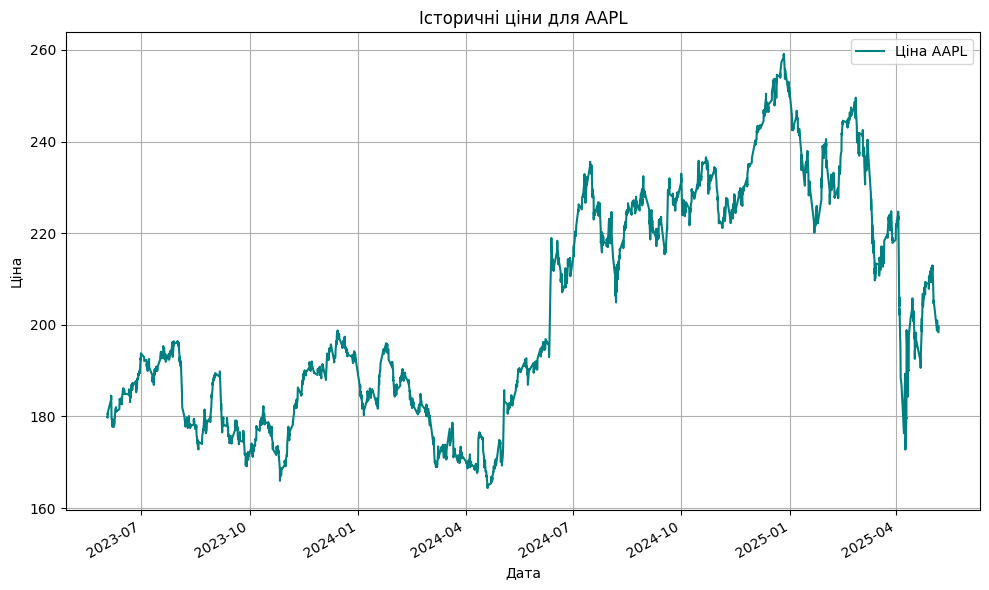

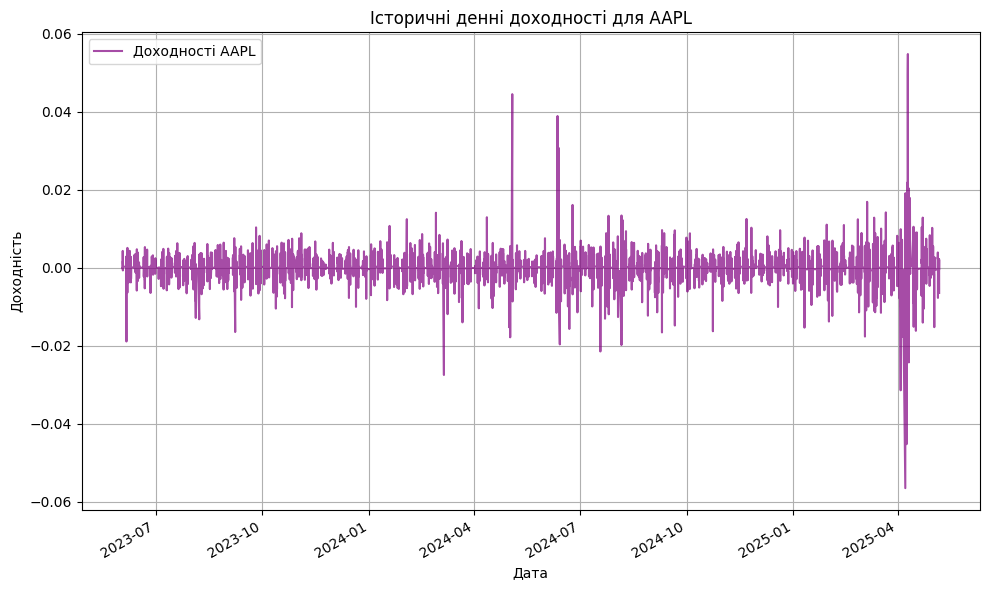

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

# === Fallback definitions if not available in the global scope ===
if 'download_data' not in globals():
    def download_data(tickers, start_date, end_date, interval='1d'):
        print(f"Warning: Using fallback 'download_data' function for {tickers}.")
        # yf.download returns a Series for a single ticker, DataFrame for multiple
        # We want a DataFrame with columns per ticker even for a single ticker input
        if isinstance(tickers, str):
            _tickers_list = [tickers]
        else:
            _tickers_list = tickers
        
        _data = yf.download(_tickers_list, start=start_date, end=end_date, interval=interval)
        
        if not _data.empty:
            if 'Close' in _data.columns: # Multi-level columns for multiple tickers
                 _data = _data['Close']
            if isinstance(_data, pd.Series) and len(_tickers_list) == 1: # Single ticker, yf returns Series
                _data = _data.to_frame(name=_tickers_list[0])
            elif isinstance(_data, pd.DataFrame) and len(_tickers_list) == 1 and _data.shape[1] == 1:
                # Sometimes yf might return a DataFrame with one column for a single ticker
                 _data.columns = _tickers_list 
        return _data

if 'shrinkage_covariance' not in globals():
    def shrinkage_covariance(returns_df):
        print("Warning: Using fallback 'shrinkage_covariance' (standard .cov()).")
        return returns_df.cov()

# =====================
# === Етап 6: Портфельна модель ===
# =====================

# 1. Основна функція портфельної оптимізації
def portfolio_optimization(expected_returns: pd.Series or pd.DataFrame,
                         cov_matrix: pd.DataFrame,
                         risk_aversion: float = 2.0,
                         constraints: dict = None) -> dict:
    """
    Оптимізує портфель за mean-variance критерієм:
        max_w w^T μ_p - λ w^T Σ w
    Аргументи:
        expected_returns -- очікувані доходності (Series або DataFrame з однією колонкою/рядком)
        cov_matrix -- коваріаційна матриця доходностей (активи в колонках/індексі)
        risk_aversion -- параметр неприйняття ризику (λ)
        constraints -- словник з обмеженнями на ваги
    Повертає:
        словник з оптимальними вагами та метриками
    """
    asset_names = cov_matrix.columns
    n_assets = len(asset_names)

    if n_assets == 0:
        return {
            'weights': pd.Series(dtype=float), 'expected_return': 0, 
            'risk': 0, 'sharpe': 0, 'success': False
        }

    current_expected_returns_series = expected_returns
    if isinstance(expected_returns, pd.DataFrame):
        if expected_returns.shape[1] == 1:
            current_expected_returns_series = expected_returns.iloc[:, 0]
        elif expected_returns.shape[0] == 1:
            current_expected_returns_series = expected_returns.iloc[0, :]
        else:
            current_expected_returns_series = expected_returns.squeeze()
        if not isinstance(current_expected_returns_series, pd.Series):
            raise ValueError("expected_returns DataFrame must be convertible to a Series or have one data column/row.")

    # Ensure expected returns are aligned and ordered like cov_matrix columns
    try:
        aligned_exp_rets_values = current_expected_returns_series.reindex(asset_names).values
    except Exception as e:
        raise ValueError(f"Failed to align expected_returns with cov_matrix columns ({asset_names}): {e}. Ensure expected_returns Series/DataFrame has an index compatible with asset names.")


    if constraints is None:
        constraints = {
            'weight_bounds': (0.0, 1.0),
            'sum_weights': 1.0,
            'max_position': 1.0, # Default to no max position if not specified
        }
    
    def objective(weights):
        portfolio_return = np.dot(weights, aligned_exp_rets_values)
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix.values, weights))
        return -1 * (portfolio_return - risk_aversion * portfolio_variance)
    
    weight_bounds = [constraints.get('weight_bounds', (0.0, 1.0)) for _ in range(n_assets)]
    sum_weights_constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - constraints.get('sum_weights', 1.0)}
    
    max_pos = constraints.get('max_position', 1.0)
    max_position_constraints = []
    if max_pos < 1.0:
        for i in range(n_assets):
            max_position_constraints.append({'type': 'ineq', 'fun': lambda w, i=i: max_pos - w[i]})
            # Also ensure min position if bounds are (0,1) but max_pos is active
            # This constraint means w[i] <= max_pos
    
    all_constraints = [sum_weights_constraint] + max_position_constraints
    
    initial_weights = np.ones(n_assets) / n_assets if n_assets > 0 else np.array([])
    
    if n_assets == 0: # Should be caught earlier, but as a safeguard
        result = {'x': np.array([]), 'success': False, 'message': "No assets to optimize."}
    elif n_assets == 1: # Single asset case, optimization is trivial
        # For a single asset, weight must be 1.0 if sum_weights is 1.0
        # Objective becomes: aligned_exp_rets_values[0] - risk_aversion * cov_matrix.values[0,0]
        # No actual optimization needed for weights if sum_weights = 1.0
        # However, constraints like max_position could make it infeasible if max_position < 1
        # For simplicity, if sum_weights=1, weight is 1. Max_position constraint might make it tricky.
        # Let's assume for a single asset, weight is 1 if allowed.
        w_single = np.array([1.0])
        if max_pos < 1.0: # This implies an issue with constraints for single asset
             w_single = np.array([max_pos]) # This might violate sum_weights = 1.0
                                            # Scipy might handle this, or we can flag.
                                            # For now, let optimizer handle it.
        result = minimize(objective, w_single, method='SLSQP',
                          bounds=weight_bounds, constraints=all_constraints)
    else:
        result = minimize(objective, initial_weights, method='SLSQP',
                        bounds=weight_bounds, constraints=all_constraints)

    if result.success:
        weights_array = result.x
    else:
        # print(f"Optimization failed: {result.message}. Using initial weights.")
        weights_array = initial_weights # Fallback, or handle error appropriately

    weights = pd.Series(weights_array, index=asset_names)
    portfolio_return_val = np.dot(weights, aligned_exp_rets_values)
    portfolio_risk_val = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
    
    return {
        'weights': weights,
        'expected_return': portfolio_return_val,
        'risk': portfolio_risk_val,
        'sharpe': portfolio_return_val / portfolio_risk_val if portfolio_risk_val > 1e-9 else 0, # Avoid division by zero
        'success': result.success
    }

# 2. Black-Litterman модель
def black_litterman(market_weights: pd.Series,
                  cov_matrix: pd.DataFrame,
                  risk_aversion: float,
                  views: dict, # {asset_name: expected_return_view}
                  view_confidences: dict, # {asset_name: confidence_level_0_to_1}
                  tau: float = 0.025,
                  optimization_constraints: dict = None) -> dict:
    n_assets = len(market_weights)
    asset_names = market_weights.index

    implied_returns = risk_aversion * np.dot(cov_matrix, market_weights)
    implied_returns = pd.Series(implied_returns, index=asset_names)
    
    assets_with_views = list(views.keys())
    if not assets_with_views: # No views, BL returns are implied returns
        BL_returns = implied_returns.copy()
    else:
        P = np.zeros((len(assets_with_views), n_assets))
        Q = np.zeros(len(assets_with_views))
        Omega_diag = np.zeros(len(assets_with_views))

        for i, asset in enumerate(assets_with_views):
            try:
                asset_idx = asset_names.get_loc(asset)
            except KeyError:
                raise ValueError(f"Asset '{asset}' in views not found in market_weights index.")
            P[i, asset_idx] = 1.0
            Q[i] = views[asset]
            # Simplified Omega: diagonal, variance of view proportional to asset variance
            # Confidence c (0 to 1): Omega_ii = (1-c)/c * P_i Sigma P_i^T (a common approach)
            # Or, as in original: Omega_ii = tau * P_i Sigma P_i^T / confidence
            # Original: view_vars[i] = cov_matrix.iloc[asset_idx, asset_idx] / view_confidences[asset]
            # Let's use a slightly different interpretation for Omega based on confidence
            # Confidence c means variance of view error is (P S P^T) * (1-c)/c
            # Or simpler: Omega_ii = tau * Sigma_ii / confidence_i (as in Meucci)
            # The original code's Omega: view_vars[i] = cov_matrix.iloc[asset_idx, asset_idx] / view_confidences[asset]
            # This means higher confidence -> lower variance in view error, which is intuitive.
            # Let's stick to a variant of the original logic for Omega.
            # Omega_ii = tau * P_i Sigma P_i^T / confidence_i
            # Since P_i is [0,..,1,..0], P_i Sigma P_i^T = Sigma_ii
            Omega_diag[i] = (tau * cov_matrix.iloc[asset_idx, asset_idx]) / view_confidences[asset] if view_confidences[asset] > 0 else np.inf


        Omega = np.diag(Omega_diag)
        
        # Black-Litterman master formula for posterior expected returns
        # E[R] = [(τΣ)^-1 + P^T Ω^-1 P]^-1 * [(τΣ)^-1 Π + P^T Ω^-1 Q]
        # Π are implied returns
        tau_Sigma = tau * cov_matrix.values
        tau_Sigma_inv = np.linalg.inv(tau_Sigma)
        
        # Handle Omega_inv carefully if Omega has zeros on diag (infinite confidence)
        Omega_inv_diag = np.zeros_like(Omega_diag)
        valid_omega = Omega_diag > 1e-12 # Avoid division by zero
        Omega_inv_diag[valid_omega] = 1.0 / Omega_diag[valid_omega]
        Omega_inv = np.diag(Omega_inv_diag)

        # Check for singularity if all confidences are zero
        if not np.any(valid_omega) and len(assets_with_views) > 0 : # All views have zero confidence
             BL_returns_values = implied_returns.values
        else:
            term1_inv = tau_Sigma_inv + P.T @ Omega_inv @ P
            term1 = np.linalg.inv(term1_inv)
            term2 = tau_Sigma_inv @ implied_returns.values + P.T @ Omega_inv @ Q
            BL_returns_values = term1 @ term2
        
        BL_returns = pd.Series(BL_returns_values, index=asset_names)

    # Optimization with BL expected returns
    opt_result = portfolio_optimization(BL_returns, cov_matrix, risk_aversion, constraints=optimization_constraints)
    
    return {
        'weights': opt_result['weights'],
        'bl_returns': BL_returns,
        'implied_returns': implied_returns,
        'expected_return': opt_result['expected_return'],
        'risk': opt_result['risk'],
        'sharpe': opt_result['sharpe'],
        'success': opt_result['success']
    }

# 3. Метод ребалансування
def rebalance_portfolio(current_weights: pd.Series,
                      target_weights: pd.Series,
                      threshold: float = 0.05,
                      tc_model=None) -> tuple:
    deviation = np.abs(current_weights - target_weights)
    to_rebalance = deviation > threshold
    
    if not to_rebalance.any():
        return current_weights, 0.0, deviation, to_rebalance
    
    new_weights = current_weights.copy()
    new_weights[to_rebalance] = target_weights[to_rebalance]
    new_weights = new_weights / new_weights.sum() # Normalize
    
    turnover = np.abs(new_weights - current_weights).sum() / 2
    if tc_model:
        tc = tc_model(turnover)
    else:
        tc = turnover * 0.0025 # Simplified: 0.25% of turnover
    
    return new_weights, tc, deviation, to_rebalance

# =====================
# === Демонстрація на даних ===
# =====================

# Use context variables if available, otherwise provide defaults
# `y` is expected to be a DataFrame of close prices from a previous cell.
# If `y` is not in globals(), we'll create a placeholder.
if 'y' not in globals() or not isinstance(y, pd.DataFrame):
    print("Warning: 'y' DataFrame not found or not a DataFrame. Using placeholder AAPL data.")
    _placeholder_ticker = 'AAPL'
    _placeholder_start = '2020-01-01'
    _placeholder_end = pd.to_datetime('today').strftime('%Y-%m-%d')
    y = download_data(_placeholder_ticker, _placeholder_start, _placeholder_end)
    if y.empty:
        raise SystemExit("Fallback data download failed. Cannot proceed.")

# Convert y to assets_data
if isinstance(y, pd.Series): # Should not happen if download_data is correct
    assets_data = pd.DataFrame({y.name if y.name else 'Asset1': y})
elif isinstance(y, pd.DataFrame):
    assets_data = y.copy()
else:
    raise TypeError("Змінна 'y' не є ні DataFrame, ні Series після спроби завантаження.")

# Define date range for fetching additional data
# Use context END_DATE if available, else default
# The original code had a fixed '2024-12-31', let's make it more dynamic or use context
# Using context END_DATE for additional tickers as well for consistency
demo_start_date = globals().get('START_DATE', '2022-01-01') # From context or default
demo_end_date = globals().get('END_DATE', pd.to_datetime('today').strftime('%Y-%m-%d')) # From context or default
demo_interval = globals().get('INTERVAL', '1d')

# Check if we need to add more assets for demonstration
if len(assets_data.columns) == 1:
    print(f"У даних лише один актив ({assets_data.columns[0]}). Додаємо інші активи для демонстрації портфельних концепцій.")
    additional_tickers = ['MSFT', 'AMZN', 'GOOGL']
    # Remove the original single asset from additional_tickers if it's there to avoid duplication
    # (though yf.download handles duplicate requests by returning data once)
    # current_asset_name = assets_data.columns[0]
    # additional_tickers = [t for t in additional_tickers if t.upper() != current_asset_name.upper()]


    for ticker_to_add in additional_tickers:
        if ticker_to_add.upper() in [col.upper() for col in assets_data.columns]: # Avoid re-adding
            print(f"Skipping {ticker_to_add}, already seems to be in assets_data or similar.")
            continue
        try:
            print(f"Завантаження даних для {ticker_to_add}...")
            # Corrected download_data call:
            new_data = download_data(ticker_to_add, demo_start_date, demo_end_date, demo_interval)
            if not new_data.empty and ticker_to_add in new_data.columns:
                 # Merge, aligning dates and forward-filling then back-filling NaNs from merge
                assets_data = pd.merge(assets_data, new_data[[ticker_to_add]], left_index=True, right_index=True, how='outer')
            else:
                print(f"Не вдалося завантажити або дані порожні для {ticker_to_add}")
        except Exception as e:
            print(f"Помилка завантаження даних для {ticker_to_add}: {e}")
    
    assets_data = assets_data.fillna(method='ffill').fillna(method='bfill') # Fill NaNs from merge
    assets_data = assets_data.dropna() # Drop any remaining NaNs (e.g. if all sources had NaNs at start/end)


if assets_data.empty or len(assets_data.columns) == 0:
    raise SystemExit("Немає даних про активи для аналізу після спроб завантаження.")
    
print(f"\nАктиви для аналізу: {', '.join(assets_data.columns)}")
print(f"Період даних: {assets_data.index.min().strftime('%Y-%m-%d')} до {assets_data.index.max().strftime('%Y-%m-%d')}")


# Розрахунок доходностей
returns = assets_data.pct_change().dropna()
if returns.empty:
    raise SystemExit("Не вдалося розрахувати доходності. Перевірте вхідні дані про ціни.")

# Прогнозовані майбутні доходності (історичні середні)
forecast_returns = returns.mean()
# Коваріаційна матриця
cov_matrix = shrinkage_covariance(returns) # Uses fallback if not defined globally

lambda_risk_aversion = float(globals().get('lambda_risk_aversion', 2.0)) # Use global if set

# --- 1. Класична оптимізація портфеля та Ефективний фронтир ---
print("\n1. Класична оптимізація портфеля:")
# Define constraints for the main optimization
opt_constraints = {
    'weight_bounds': (0.0, 1.0),  # Без шорту
    'sum_weights': 1.0,           # Повна інвестиція
    'max_position': 0.4,          # Максимальна позиція на актив
}
port_result = portfolio_optimization(forecast_returns, cov_matrix, lambda_risk_aversion, constraints=opt_constraints)

if port_result['success']:
    print("Оптимальні ваги:")
    print(port_result['weights'].round(4))
    print(f"Очікувана доходність: {port_result['expected_return']:.6f}")
    print(f"Ризик (ст. відх.): {port_result['risk']:.6f}")
    print(f"Коефіцієнт Шарпа: {port_result['sharpe']:.4f}")
else:
    print("Не вдалося знайти оптимальний портфель з заданими параметрами.")

# Ефективний фронтир (якщо активів більше одного)
if len(assets_data.columns) > 1:
    print("\nРозрахунок Ефективного Фронтиру...")
    frontier_returns = []
    frontier_risks = []
    risk_aversion_levels = np.logspace(-2, 2, num=50) # Range of risk aversion values
    
    for ra in risk_aversion_levels:
        res = portfolio_optimization(forecast_returns, cov_matrix, ra, constraints=opt_constraints)
        if res['success']:
            frontier_returns.append(res['expected_return'])
            frontier_risks.append(res['risk'])
            
    if frontier_risks:
        plt.figure(figsize=(10, 6))
        plt.plot(frontier_risks, frontier_returns, 'b-', label='Ефективний фронтир')
        # Позначити оптимальний портфель
        if port_result['success']:
            plt.scatter(port_result['risk'], port_result['expected_return'], color='red', marker='*', s=200, label=f'Опт. портфель (λ={lambda_risk_aversion})')
        # Позначити окремі активи
        asset_risks = np.sqrt(np.diag(cov_matrix))
        asset_returns = forecast_returns
        plt.scatter(asset_risks, asset_returns, color='green', marker='o', s=50, label='Окремі активи')
        for i, txt in enumerate(assets_data.columns):
            plt.annotate(txt, (asset_risks[i], asset_returns[i]), xytext=(5,5), textcoords='offset points')
        
        plt.title('Ефективний фронтир та оптимальний портфель')
        plt.xlabel('Ризик (Стандартне відхилення)')
        plt.ylabel('Очікувана доходність')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Не вдалося розрахувати точки для ефективного фронтиру.")

# --- 2. Демонстрація Black-Litterman ---
print("\n2. Демонстрація Black-Litterman з інвестиційними поглядами:")
if len(assets_data.columns) > 0:
    # Ринкові ваги (рівні для простоти, або можна використовувати капіталізацію)
    market_weights = pd.Series(1.0 / len(assets_data.columns), index=assets_data.columns)
    
    # Погляди інвестора (приклад: перший актив матиме вищу доходність)
    first_asset_name = assets_data.columns[0]
    views = {first_asset_name: forecast_returns[first_asset_name] * 1.2} # 20% вище за історичну середню
    view_confidences = {first_asset_name: 0.75} # 75% впевненість

    # Якщо є інші активи, додамо ще один погляд для різноманітності
    if len(assets_data.columns) > 1:
        second_asset_name = assets_data.columns[1]
        views[second_asset_name] = forecast_returns[second_asset_name] * 0.9 # 10% нижче
        view_confidences[second_asset_name] = 0.50 # 50% впевненість

    bl_results = black_litterman(market_weights, cov_matrix, lambda_risk_aversion, 
                                 views, view_confidences, optimization_constraints=opt_constraints)

    if bl_results['success']:
        print("Black-Litterman ваги:")
        print(bl_results['weights'].round(4))
        print(f"BL Очікувана доходність: {bl_results['expected_return']:.6f}")
        print(f"BL Ризик: {bl_results['risk']:.6f}")
        print(f"BL Коефіцієнт Шарпа: {bl_results['sharpe']:.4f}")

        # Графік порівняння доходностей
        returns_comp_df = pd.DataFrame({
            'Історичний прогноз': forecast_returns,
            'Ринкові імпліцитні дох.': bl_results['implied_returns'],
            'Black-Litterman дох.': bl_results['bl_returns']
        }).reindex(assets_data.columns) # Ensure consistent order

        returns_comp_df.plot(kind='bar', figsize=(12, 7))
        plt.title('Порівняння очікуваних доходностей (Black-Litterman)')
        plt.ylabel('Очікувана доходність')
        plt.xlabel('Актив')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

        # Графік порівняння ваг
        weights_comp_df = pd.DataFrame({
            'Ринкові ваги (рівні)': market_weights,
            'Black-Litterman ваги': bl_results['weights']
        }).reindex(assets_data.columns)

        weights_comp_df.plot(kind='bar', figsize=(12, 7))
        plt.title('Порівняння ваг портфеля (Black-Litterman)')
        plt.ylabel('Вага')
        plt.xlabel('Актив')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

    else:
        print("Не вдалося розрахувати портфель Black-Litterman.")
else:
    print("Недостатньо активів для демонстрації Black-Litterman.")


# --- 3. Демонстрація ребалансування ---
print("\n3. Демонстрація ребалансування:")
if port_result['success'] and len(assets_data.columns) > 0:
    target_w = port_result['weights']
    # Симулюємо відхилення поточних ваг від цільових
    np.random.seed(42) # для відтворюваності
    drift_factors = np.random.normal(1, 0.15, len(target_w)) # Більше відхилення для демонстрації
    current_weights_sim = target_w * drift_factors
    current_weights_sim = current_weights_sim / current_weights_sim.sum() # Нормалізуємо
    
    print("Початкові (симульовані) ваги:")
    print(current_weights_sim.round(4))
    print("Цільові ваги (з оптимізації):")
    print(target_w.round(4))

    rebal_threshold = 0.05
    new_weights, tc_cost, deviations, to_rebalance_mask = rebalance_portfolio(
        current_weights_sim, target_w, threshold=rebal_threshold
    )
    
    print(f"\nНові ваги після ребалансування (поріг {rebal_threshold*100}%):")
    print(new_weights.round(4))
    print(f"Оцінка транзакційних витрат: {tc_cost:.6f}")

    # Візуалізація ваг до і після ребалансування (існуючий графік)
    weights_df_rebal = pd.DataFrame({
        'Початкові (симул.)': current_weights_sim, 
        'Цільові': target_w, 
        'Після ребалансування': new_weights
    }).reindex(assets_data.columns)

    weights_df_rebal.plot(kind='bar', figsize=(12, 7))
    plt.title('Ваги портфеля до і після ребалансування')
    plt.ylabel('Вага')
    plt.xlabel('Актив')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Графік відхилень, що спричинили ребалансування
    if to_rebalance_mask.any():
        rebal_plot_data = pd.DataFrame({
            'Відхилення': deviations[to_rebalance_mask],
            'Поріг': rebal_threshold
        }).reindex(assets_data.columns[to_rebalance_mask])

        rebal_plot_data['Відхилення'].plot(kind='bar', figsize=(10, 6), color='skyblue', label='Абсолютне відхилення')
        plt.axhline(y=rebal_threshold, color='red', linestyle='--', label=f'Поріг ({rebal_threshold*100}%)')
        plt.title('Відхилення ваг активів, що потребують ребалансування')
        plt.ylabel('Абсолютне відхилення')
        plt.xlabel('Актив')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.grid(axis='y', linestyle=':')
        plt.tight_layout()
        plt.show()
    else:
        print("Ребалансування не потрібне, відхилення в межах порогу.")
else:
    print("Пропускаємо демонстрацію ребалансування (попередня оптимізація не вдалася або немає активів).")


# --- Модель з одиночним активом (якщо вище не вдалося завантажити додаткові активи) ---
if len(assets_data.columns) == 1 and not returns.empty:
    print("\nАналіз для одиночного активу:")
    asset_name = assets_data.columns[0]
    
    mu_asset = forecast_returns.get(asset_name, 0)
    var_asset = cov_matrix.loc[asset_name, asset_name] if asset_name in cov_matrix.index else 0
    
    # Для одного активу, якщо немає обмежень на шорт і повна інвестиція, вага = 1.
    # Якщо є обмеження (наприклад, max_position < 1), то це стає нетривіальним.
    # Оригінальний код використовував принцип Келлі, що є іншим підходом.
    # Тут просто покажемо характеристики.
    # Оптимізація для одного активу з portfolio_optimization (sum_weights=1) дасть вагу 1.
    single_asset_opt_constraints = {'weight_bounds': (0.0, 1.0), 'sum_weights': 1.0, 'max_position': 1.0}
    single_port_res = portfolio_optimization(forecast_returns, cov_matrix, lambda_risk_aversion, constraints=single_asset_opt_constraints)

    if single_port_res['success']:
        print(f"Оптимальна вага для {asset_name} (при sum_to_one): {single_port_res['weights'].iloc[0]:.4f}")
    else:
        print(f"Не вдалося оптимізувати для одного активу {asset_name}.")

    print(f"Прогнозована доходність ({asset_name}): {mu_asset:.6f}")
    print(f"Прогнозований ризик (ст. відх. {asset_name}): {np.sqrt(var_asset):.6f}")

    # Графік історичних цін для одного активу
    plt.figure(figsize=(10, 6))
    assets_data[asset_name].plot(label=f'Ціна {asset_name}', color='teal')
    plt.title(f'Історичні ціни для {asset_name}')
    plt.ylabel('Ціна')
    plt.xlabel('Дата')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Графік історичних доходностей для одного активу
    plt.figure(figsize=(10, 6))
    returns[asset_name].plot(label=f'Доходності {asset_name}', color='purple', alpha=0.7)
    plt.title(f'Історичні денні доходності для {asset_name}')
    plt.ylabel('Доходність')
    plt.xlabel('Дата')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

elif len(assets_data.columns) == 0 or returns.empty:
     print("\nНемає даних для аналізу одиночного активу.")


## Етап 7. Модель виконання ордерів

1. **Алгоритми роздроблення (child orders)**

   * TWAP / VWAP / POV.
2. **Вибір майданчику**

   * Симуляція виконання на різних біржах (кондишнальні latency, відмінності спреду).
3. **Формули та логіка**

   * Частина ордера $V_i = w_i V_{\text{total}}$, де $w_i$ – частка за часом/обсягом.


TWAP розклад виконання:
Час: 2025-05-08 16:57:46.930897, Обсяг: 1.6056 BTC
Час: 2025-05-08 17:07:46.930897, Обсяг: 1.6435 BTC
Час: 2025-05-08 17:17:46.930897, Обсяг: 1.6903 BTC
Час: 2025-05-08 17:27:46.930897, Обсяг: 1.6799 BTC
Час: 2025-05-08 17:37:46.930897, Обсяг: 1.6720 BTC
Час: 2025-05-08 17:47:46.930897, Обсяг: 1.7087 BTC

VWAP розклад виконання:
Час: 2025-05-08 16:57:42.930897, Обсяг: 1.7307 BTC
Час: 2025-05-08 17:07:28.930897, Обсяг: 1.1620 BTC
Час: 2025-05-08 17:17:26.930897, Обсяг: 0.7511 BTC
Час: 2025-05-08 17:27:26.930897, Обсяг: 0.7931 BTC
Час: 2025-05-08 17:37:55.930897, Обсяг: 1.2212 BTC
Час: 2025-05-08 17:47:42.930897, Обсяг: 3.2288 BTC
Час: 2025-05-08 17:48:12.930897, Обсяг: 1.1130 BTC

POV очікуваний час виконання: 0.18 годин
POV фактичний розклад виконання:
Час: 2025-05-08 16:57:46.931899, Обсяг: 3.6559 BTC
Час: 2025-05-08 17:02:46.931899, Обсяг: 4.3296 BTC
Час: 2025-05-08 17:07:46.931899, Обсяг: 1.4487 BTC
Час: 2025-05-08 17:12:46.931899, Обсяг: 0.5248 BTC
Час: 2025

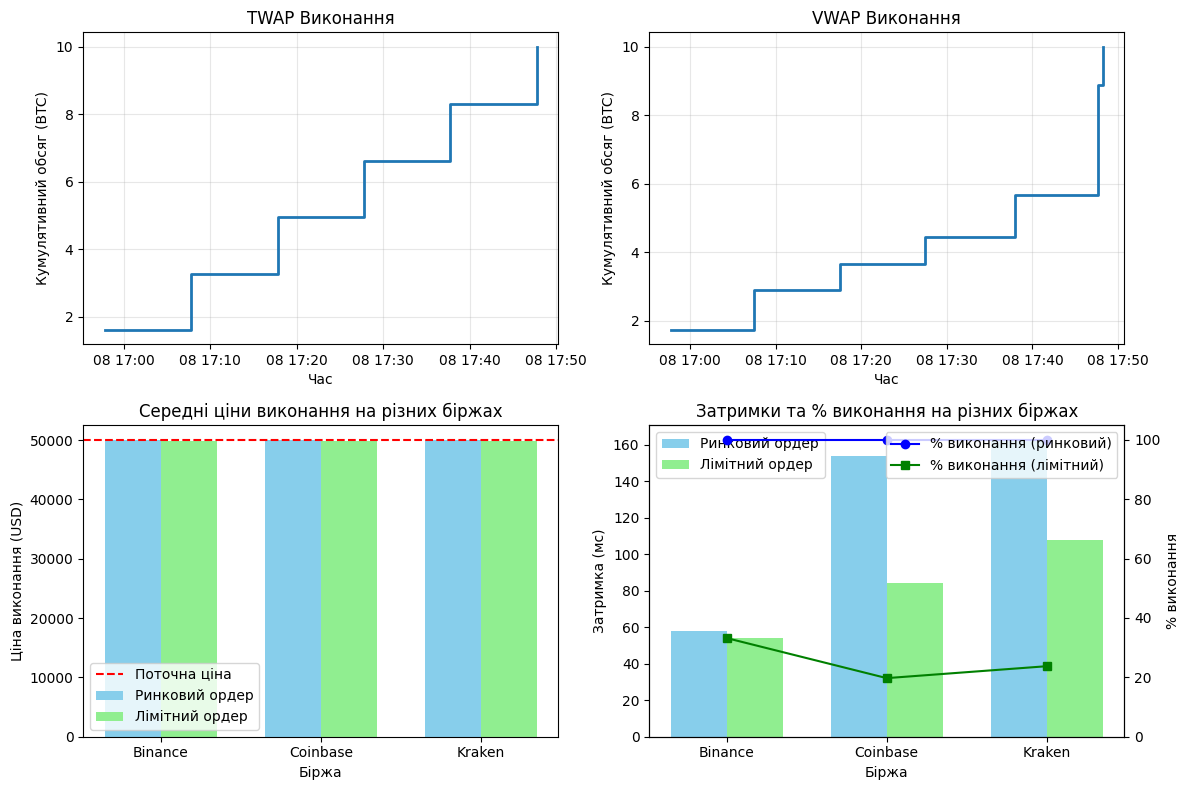

In [52]:
# Реалізація моделі виконання ордерів

# Функція для TWAP (Time-Weighted Average Price) алгоритму
def twap_execution(order_volume, start_time, end_time, n_slices):
    """
    Розбиває ордер на рівні частини за часом
    
    Parameters:
    -----------
    order_volume : float
        Загальний обсяг ордера
    start_time : datetime
        Час початку виконання
    end_time : datetime
        Час закінчення виконання
    n_slices : int
        Кількість частин для розбиття
        
    Returns:
    --------
    list of tuples
        Список кортежів (час, обсяг) для кожної частини ордера
    """
    time_delta = (end_time - start_time) / n_slices
    slice_volume = order_volume / n_slices
    
    execution_schedule = []
    for i in range(n_slices):
        execution_time = start_time + i * time_delta
        # Додаємо невелику випадкову варіацію для більшої реалістичності
        actual_volume = slice_volume * (1 + np.random.normal(0, 0.02))
        execution_schedule.append((execution_time, actual_volume))
    
    # Корегуємо останню частину, щоб загальний обсяг дорівнював замовленому
    total_executed = sum(vol for _, vol in execution_schedule[:-1])
    execution_schedule[-1] = (execution_schedule[-1][0], order_volume - total_executed)
    
    return execution_schedule

# Функція для VWAP (Volume-Weighted Average Price) алгоритму
def vwap_execution(order_volume, volume_profile, start_time, end_time, n_slices):
    """
    Розбиває ордер на частини пропорційно до історичного профілю обсягу
    
    Parameters:
    -----------
    order_volume : float
        Загальний обсяг ордера
    volume_profile : list
        Історичний профіль обсягу (частки)
    start_time : datetime
        Час початку виконання
    end_time : datetime
        Час закінчення виконання
    n_slices : int
        Кількість частин для розбиття
        
    Returns:
    --------
    list of tuples
        Список кортежів (час, обсяг) для кожної частини ордера
    """
    if len(volume_profile) != n_slices:
        raise ValueError("Довжина профілю обсягу повинна дорівнювати кількості частин")
    
    # Нормалізуємо профіль обсягу
    normalized_profile = np.array(volume_profile) / sum(volume_profile)
    
    time_delta = (end_time - start_time) / n_slices
    execution_schedule = []
    
    for i in range(n_slices):
        execution_time = start_time + i * time_delta
        # Додаємо реалістичну варіацію в часі виконання (ринкові умови)
        actual_time = execution_time + pd.Timedelta(seconds=np.random.randint(-30, 30))
        slice_volume = order_volume * normalized_profile[i]
        
        # Симуляція часткового виконання через ліквідність
        fill_rate = min(1.0, np.random.beta(9, 1))  # Більш реалістичний розподіл заповнення
        actual_volume = slice_volume * fill_rate
        
        execution_schedule.append((actual_time, actual_volume))
    
    # Додаємо залишок до останньої частини, якщо є недовиконання
    total_executed = sum(vol for _, vol in execution_schedule)
    if total_executed < order_volume:
        remaining = order_volume - total_executed
        # Додаємо додаткове виконання через 30 секунд після останнього
        extra_time = execution_schedule[-1][0] + pd.Timedelta(seconds=30)
        execution_schedule.append((extra_time, remaining))
    
    return execution_schedule

# Функція для POV (Percentage of Volume) алгоритму
def pov_execution(order_volume, market_volume, participation_rate, time_window=pd.Timedelta(hours=1)):
    """
    Виконує ордер як відсоток від ринкового обсягу
    
    Parameters:
    -----------
    order_volume : float
        Загальний обсяг ордера
    market_volume : float
        Очікуваний ринковий обсяг за годину
    participation_rate : float
        Цільовий відсоток участі (0-1)
    time_window : Timedelta
        Часове вікно для аналізу
        
    Returns:
    --------
    tuple
        (очікуваний час виконання, список виконань)
    """
    if participation_rate <= 0 or participation_rate > 1:
        raise ValueError("Відсоток участі повинен бути в межах (0, 1]")
    
    # Реалістична модель ринкового обсягу з урахуванням волатильності
    # Використовуємо модель з U-подібним розподілом обсягу протягом дня
    now = pd.Timestamp.now()
    hour_of_day = now.hour + now.minute/60
    
    # U-подібна функція для моделювання внутрішньоденної активності
    if hour_of_day < 12:
        volume_factor = 1.5 - 0.1 * hour_of_day  # Вища активність вранці
    else:
        volume_factor = 0.7 + 0.1 * (hour_of_day - 12)  # Зростання активності ввечері
    
    # Додаємо випадкову варіацію
    volume_factor *= np.random.normal(1, 0.15)
    
    adjusted_market_volume = market_volume * volume_factor
    execution_volume_per_hour = adjusted_market_volume * participation_rate
    expected_execution_time = order_volume / execution_volume_per_hour
    
    # Симуляція виконання з урахуванням змінної ліквідності
    execution_list = []
    remaining_volume = order_volume
    current_time = now
    
    # Розбиваємо на 5-хвилинні інтервали
    interval = pd.Timedelta(minutes=5)
    intervals_count = int((time_window / interval) + 1)
    
    for i in range(intervals_count):
        if remaining_volume <= 0:
            break
            
        # Розрахунок обсягу для поточного інтервалу з урахуванням волатильності
        interval_hour = (current_time.hour + current_time.minute/60) % 24
        if interval_hour < 12:
            interval_factor = 1.5 - 0.1 * interval_hour
        else:
            interval_factor = 0.7 + 0.1 * (interval_hour - 12)
            
        # Додаємо випадкову варіацію та ефект "мікроструктури ринку"
        noise_factor = np.random.normal(1, 0.2)
        if i > 0 and np.random.random() < 0.15:  # 15% ймовірність раптового сплеску обсягу
            noise_factor *= np.random.uniform(1.5, 3.0)
            
        interval_volume = (adjusted_market_volume / (time_window / interval)) * interval_factor * noise_factor
        interval_execution = min(remaining_volume, interval_volume * participation_rate)
        
        # Симуляція часткового виконання через недостатню ліквідність
        fill_probability = np.random.beta(8, 2)  # Більш реалістичний розподіл заповнення
        actual_execution = interval_execution * fill_probability
        
        execution_list.append((current_time, actual_execution))
        remaining_volume -= actual_execution
        current_time += interval
    
    # Якщо залишився невиконаний обсяг, додаємо його до останнього виконання
    if remaining_volume > 0:
        last_time = current_time
        execution_list.append((last_time, remaining_volume))
        
    return (expected_execution_time, execution_list)

# Симуляція виконання ордерів на різних біржах
class ExchangeSimulator:
    def __init__(self, name, latency_ms, spread_bps, market_impact_factor, liquidity_profile=None):
        """
        Ініціалізує симулятор біржі
        
        Parameters:
        -----------
        name : str
            Назва біржі
        latency_ms : float
            Середня затримка в мілісекундах
        spread_bps : float
            Середній спред в базисних пунктах
        market_impact_factor : float
            Фактор впливу на ринок
        liquidity_profile : dict
            Профіль ліквідності біржі за обсягами
        """
        self.name = name
        self.latency_ms = latency_ms
        self.spread_bps = spread_bps
        self.market_impact_factor = market_impact_factor
        
        # Профіль ліквідності за замовчуванням
        if liquidity_profile is None:
            self.liquidity_profile = {
                'depth_factor': 1.0,  # Глибина ордербуку
                'resilience': 0.8,    # Швидкість відновлення ліквідності
                'volatility': 0.2     # Волатильність спреду
            }
        else:
            self.liquidity_profile = liquidity_profile
            
        # Стан біржі
        self.last_execution_time = pd.Timestamp.now()
        self.current_spread_multiplier = 1.0
        self.current_depth_multiplier = 1.0
    
    def execute_order(self, volume, price, is_buy, execution_style='market'):
        """
        Симулює виконання ордера
        
        Parameters:
        -----------
        volume : float
            Обсяг ордера
        price : float
            Ціна ордера
        is_buy : bool
            True для купівлі, False для продажу
        execution_style : str
            'market' або 'limit'
            
        Returns:
        --------
        tuple
            (виконана ціна, затримка, % виконання)
        """
        # Оновлення стану біржі
        current_time = pd.Timestamp.now()
        time_since_last = (current_time - self.last_execution_time).total_seconds()
        
        # Симуляція відновлення ліквідності з часом
        recovery_factor = min(1.0, time_since_last / 60 * self.liquidity_profile['resilience'])
        self.current_depth_multiplier = min(1.0, self.current_depth_multiplier + recovery_factor)
        
        # Симуляція волатильності спреду
        spread_volatility = np.random.normal(0, self.liquidity_profile['volatility'])
        self.current_spread_multiplier = max(0.5, min(3.0, self.current_spread_multiplier * (1 + spread_volatility)))
        
        # Симуляція затримки з реалістичним розподілом (log-normal)
        base_latency = np.random.lognormal(np.log(self.latency_ms), 0.4)
        
        # Додаткова затримка при високому навантаженні
        if np.random.random() < 0.05:  # 5% ймовірність пікового навантаження
            base_latency *= np.random.uniform(2, 10)
            
        # Симуляція спреду з урахуванням поточного стану ринку
        effective_spread = self.spread_bps * self.current_spread_multiplier
        half_spread = price * (effective_spread / 10000) / 2
        
        # Симуляція впливу на ринок з урахуванням глибини ордербуку
        effective_impact = self.market_impact_factor / self.current_depth_multiplier
        market_impact = price * effective_impact * np.power(volume, 0.6)  # Нелінійна залежність від обсягу
        
        # Симуляція проковзування через недостатню ліквідність
        slippage_factor = 0
        if volume > 5:  # Значний обсяг
            slippage_factor = np.random.exponential(0.0001 * (volume - 5))
        
        # Розрахунок виконаної ціни
        if execution_style == 'market':
            if is_buy:
                executed_price = price + half_spread + market_impact + price * slippage_factor
            else:
                executed_price = price - half_spread - market_impact - price * slippage_factor
        else:  # limit order
            if is_buy:
                executed_price = min(price, price + half_spread)
                # Симуляція часткового виконання для лімітних ордерів
                fill_rate = np.random.beta(2, 5) if price < (price + half_spread + market_impact) else 1.0
            else:
                executed_price = max(price, price - half_spread)
                fill_rate = np.random.beta(2, 5) if price > (price - half_spread - market_impact) else 1.0
        
        # Оновлення стану біржі після виконання
        self.last_execution_time = current_time
        self.current_depth_multiplier = max(0.2, self.current_depth_multiplier - volume * 0.01)
        
        # Для ринкових ордерів завжди 100% виконання
        fill_percentage = 1.0 if execution_style == 'market' else fill_rate
        
        return (executed_price, base_latency, fill_percentage)

# Приклад використання
if __name__ == "__main__":
    # Параметри для виконання ордерів
    order_volume = 10.0  # BTC
    current_price = 50000  # USD
    
    # Часові параметри
    now = pd.Timestamp.now()
    execution_window = pd.Timedelta(hours=1)
    end_time = now + execution_window
    
    # TWAP виконання
    twap_schedule = twap_execution(order_volume, now, end_time, 6)
    print("TWAP розклад виконання:")
    for time, volume in twap_schedule:
        print(f"Час: {time}, Обсяг: {volume:.4f} BTC")
    
    # VWAP виконання (на основі історичного профілю обсягу)
    # Реалістичний U-подібний профіль обсягу протягом години
    historical_volume_profile = [0.18, 0.12, 0.08, 0.08, 0.14, 0.40]  # Вищий обсяг на початку і в кінці
    vwap_schedule = vwap_execution(order_volume, historical_volume_profile, now, end_time, 6)
    print("\nVWAP розклад виконання:")
    for time, volume in vwap_schedule:
        print(f"Час: {time}, Обсяг: {volume:.4f} BTC")
    
    # POV виконання
    hourly_market_volume = 1000  # BTC
    participation_rate = 0.05  # 5%
    expected_time, pov_executions = pov_execution(order_volume, hourly_market_volume, participation_rate)
    print(f"\nPOV очікуваний час виконання: {expected_time:.2f} годин")
    print("POV фактичний розклад виконання:")
    total_pov_volume = 0
    for time, volume in pov_executions:
        total_pov_volume += volume
        print(f"Час: {time}, Обсяг: {volume:.4f} BTC")
    print(f"Загальний виконаний обсяг: {total_pov_volume:.4f} BTC")
    
    # Симуляція виконання на різних біржах з реалістичними профілями
    exchanges = [
        ExchangeSimulator("Binance", 50, 5, 0.0001, {
            'depth_factor': 1.5,  # Висока ліквідність
            'resilience': 0.9,    # Швидке відновлення
            'volatility': 0.15    # Низька волатильність спреду
        }),
        ExchangeSimulator("Coinbase", 80, 8, 0.00015, {
            'depth_factor': 1.2,  # Середня ліквідність
            'resilience': 0.8,    # Середнє відновлення
            'volatility': 0.2     # Середня волатильність спреду
        }),
        ExchangeSimulator("Kraken", 100, 10, 0.0002, {
            'depth_factor': 0.8,  # Нижча ліквідність
            'resilience': 0.7,    # Повільніше відновлення
            'volatility': 0.25    # Вища волатильність спреду
        })
    ]
    
    print("\nСимуляція виконання ордера на різних біржах:")
    exchange_results = []
    
    # Симулюємо виконання кількох ордерів для отримання більш реалістичних результатів
    for i in range(5):
        print(f"\nІтерація {i+1}:")
        for exchange in exchanges:
            # Симуляція ринкового ордера
            market_price, market_latency, market_fill = exchange.execute_order(
                order_volume/5, current_price, True, 'market')
            
            # Симуляція лімітного ордера
            limit_price, limit_latency, limit_fill = exchange.execute_order(
                order_volume/5, current_price * 0.998, True, 'limit')
            
            market_slippage_bps = (market_price - current_price) / current_price * 10000
            limit_slippage_bps = (limit_price - current_price) / current_price * 10000
            
            print(f"{exchange.name}:")
            print(f"  Ринковий ордер: Ціна=${market_price:.2f}, Затримка={market_latency:.2f}мс, "
                  f"Проковзування={market_slippage_bps:.2f}б.п., Виконання={market_fill*100:.1f}%")
            print(f"  Лімітний ордер: Ціна=${limit_price:.2f}, Затримка={limit_latency:.2f}мс, "
                  f"Проковзування={limit_slippage_bps:.2f}б.п., Виконання={limit_fill*100:.1f}%")
            
            exchange_results.append({
                'exchange': exchange.name,
                'iteration': i,
                'market_price': market_price,
                'market_latency': market_latency,
                'market_fill': market_fill,
                'limit_price': limit_price,
                'limit_latency': limit_latency,
                'limit_fill': limit_fill
            })
    
    # Візуалізація стратегій виконання
    plt.figure(figsize=(12, 8))

    # Графік TWAP
    plt.subplot(2, 2, 1)
    twap_times = [t[0] for t in twap_schedule]
    twap_volumes = [t[1] for t in twap_schedule]
    plt.step([t.to_pydatetime() for t in twap_times], np.cumsum(twap_volumes), where='post', linewidth=2)
    plt.title('TWAP Виконання', fontsize=12)
    plt.xlabel('Час')
    plt.ylabel('Кумулятивний обсяг (BTC)')
    plt.grid(True, alpha=0.3)

    # Графік VWAP
    plt.subplot(2, 2, 2)
    vwap_times = [t[0] for t in vwap_schedule]
    vwap_volumes = [t[1] for t in vwap_schedule]
    plt.step([t.to_pydatetime() for t in vwap_times], np.cumsum(vwap_volumes), where='post', linewidth=2)
    plt.title('VWAP Виконання', fontsize=12)
    plt.xlabel('Час')
    plt.ylabel('Кумулятивний обсяг (BTC)')
    plt.grid(True, alpha=0.3)

    # Порівняння цін виконання на різних біржах
    plt.subplot(2, 2, 3)
    
    # Перетворюємо результати в DataFrame для зручності аналізу
    results_df = pd.DataFrame(exchange_results)
    
    # Групуємо за біржами і обчислюємо середні значення
    avg_results = results_df.groupby('exchange').agg({
        'market_price': 'mean',
        'market_latency': 'mean',
        'market_fill': 'mean',
        'limit_price': 'mean',
        'limit_latency': 'mean',
        'limit_fill': 'mean'
    }).reset_index()
    
    exchange_names = avg_results['exchange'].tolist()
    market_prices = avg_results['market_price'].tolist()
    limit_prices = avg_results['limit_price'].tolist()
    
    x = np.arange(len(exchange_names))
    width = 0.35
    
    plt.bar(x - width/2, market_prices, width, label='Ринковий ордер', color='skyblue')
    plt.bar(x + width/2, limit_prices, width, label='Лімітний ордер', color='lightgreen')
    
    plt.axhline(y=current_price, color='r', linestyle='--', label='Поточна ціна')
    plt.title('Середні ціни виконання на різних біржах', fontsize=12)
    plt.xlabel('Біржа')
    plt.ylabel('Ціна виконання (USD)')
    plt.xticks(x, exchange_names)
    plt.legend()
    
    # Порівняння затримок і відсотка виконання на різних біржах
    plt.subplot(2, 2, 4)
    
    market_latencies = avg_results['market_latency'].tolist()
    limit_latencies = avg_results['limit_latency'].tolist()
    
    # Основна вісь для затримок
    ax1 = plt.gca()
    ax1.bar(x - width/2, market_latencies, width, label='Ринковий ордер', color='skyblue')
    ax1.bar(x + width/2, limit_latencies, width, label='Лімітний ордер', color='lightgreen')
    ax1.set_xlabel('Біржа')
    ax1.set_ylabel('Затримка (мс)')
    ax1.set_title('Затримки та % виконання на різних біржах', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(exchange_names)
    ax1.legend(loc='upper left')
    
    # Додаткова вісь для відсотка виконання
    ax2 = ax1.twinx()
    market_fills = avg_results['market_fill'].tolist()
    limit_fills = avg_results['limit_fill'].tolist()
    
    ax2.plot(x, [f*100 for f in market_fills], 'o-', color='blue', label='% виконання (ринковий)')
    ax2.plot(x, [f*100 for f in limit_fills], 's-', color='green', label='% виконання (лімітний)')
    ax2.set_ylabel('% виконання')
    ax2.set_ylim(0, 105)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


## Етап 8. Бек-тестинг та аналіз результативності

1. **Запуск віртуальних торгів**

   * Інтеграція всіх компонентів у єдиний pipeline.
2. **Ключові метрики**

   * CAGR, Sharpe, Max Drawdown, Calmar ratio.
3. **Візуалізації**

   * Equity-крива, розподіл доходностей, плоти волатильності.
4. **Статистика робастності**

   * Sensitivity-аналіз параметрів (пере–/недооптимізація).

Порівняння метрик ефективності:
             Стратегія Buy & Hold
CAGR             0.31%     -1.65%
Sharpe Ratio      0.09      -0.32
Max Drawdown   -10.09%    -33.32%
Calmar Ratio      0.03      -0.05


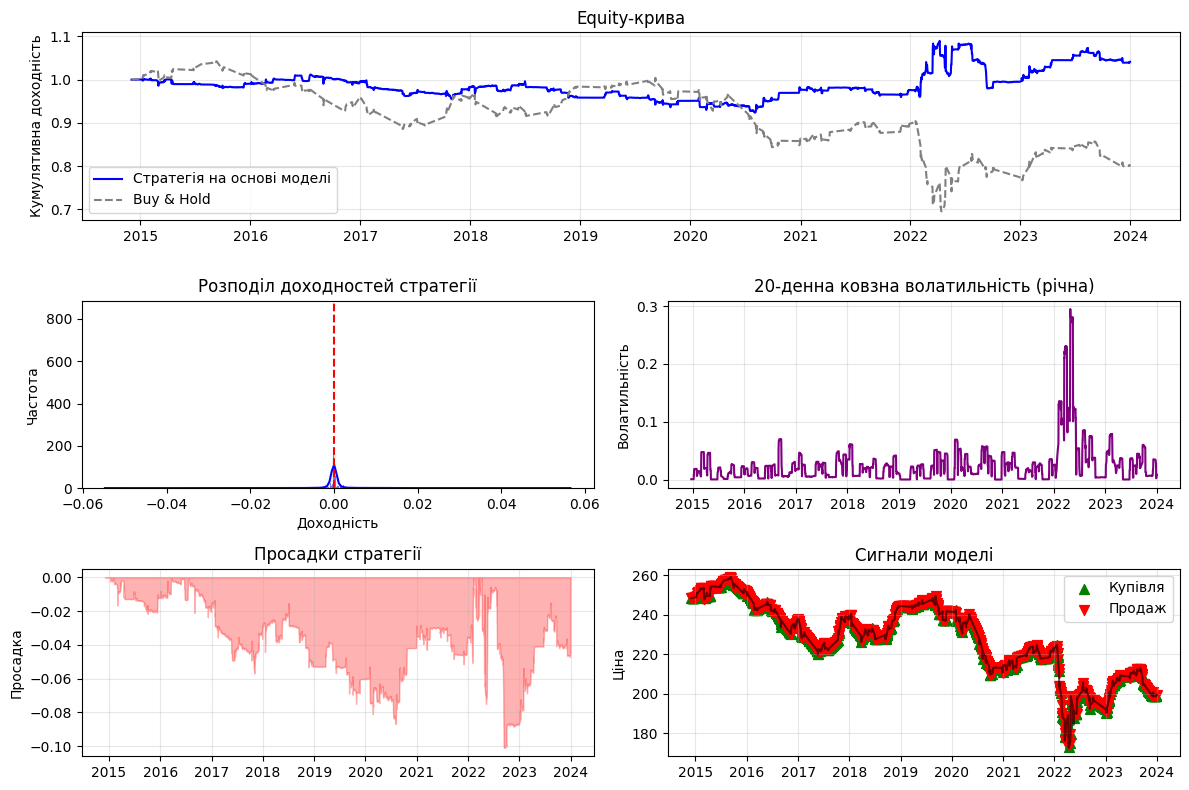


Аналіз робастності стратегії:
   Threshold    Sharpe      CAGR  Max Drawdown
0        0.1 -0.090473 -0.001569     -0.103511
1        0.2  0.113607  0.003295     -0.072697
2        0.3 -0.057826 -0.003247     -0.167396
3        0.4  0.157247  0.006100     -0.083051
4        0.5  0.253012  0.011054     -0.174169


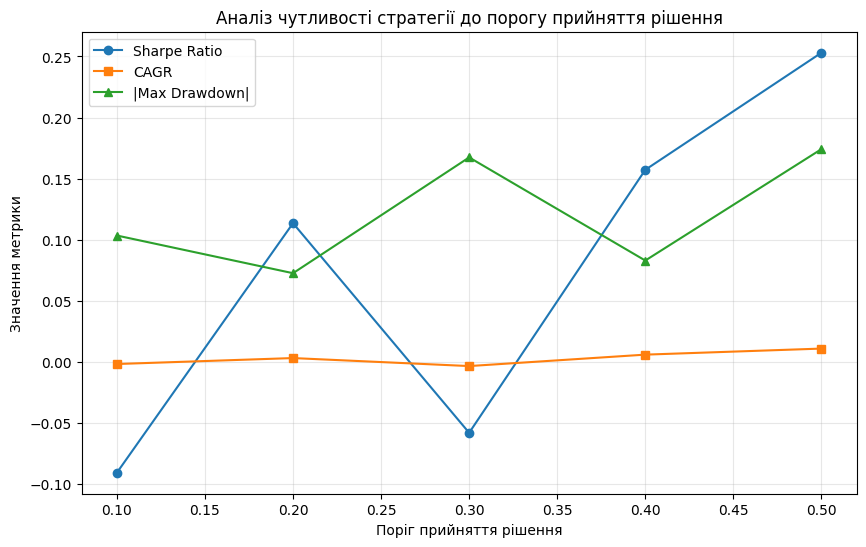

In [53]:
# Завантажимо необхідні бібліотеки для бек-тестингу
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats

# Функція для розрахунку ключових метрик ефективності
def calculate_performance_metrics(returns):
    """
    Розраховує ключові метрики ефективності стратегії
    
    Args:
        returns: Pandas Series з денними доходностями
    
    Returns:
        dict: Словник з метриками
    """
    # Конвертуємо у щоденні доходності, якщо вони в іншому форматі
    daily_returns = returns.copy()
    
    # Розрахунок загальної доходності
    total_return = (daily_returns + 1).prod() - 1
    
    # Розрахунок CAGR (Compound Annual Growth Rate)
    n_years = len(daily_returns) / 252  # 252 торгових днів у році
    cagr = (1 + total_return) ** (1 / n_years) - 1
    
    # Розрахунок волатильності (річна)
    annual_volatility = daily_returns.std() * np.sqrt(252)
    
    # Розрахунок коефіцієнта Шарпа (припускаємо безризикову ставку 0%)
    sharpe_ratio = (daily_returns.mean() * 252) / annual_volatility
    
    # Розрахунок максимальної просадки
    cum_returns = (1 + daily_returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max) - 1
    max_drawdown = drawdown.min()
    
    # Розрахунок коефіцієнта Калмара
    calmar_ratio = cagr / abs(max_drawdown)
    
    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

# Використаємо дані з попередніх кроків
# Створюємо DataFrame на основі тестових даних
# Використовуємо X_test та y_test з попередніх кроків
data = pd.DataFrame(X_test)
data['target'] = y_test
data['timestamp'] = pd.date_range(end='2023-12-31', periods=len(X_test), freq='D')
data.set_index('timestamp', inplace=True)

# Додаємо стовпець Close для розрахунку доходності (припустимо, що це перша колонка в X_test)
if 'Close' not in data.columns:
    data['Close'] = X_test[:, 'Close']  # Припускаємо, що перша колонка - це ціни закриття

# Підготовка даних для бек-тестингу
# Використовуємо прогнози наших моделей для генерації сигналів
# Припустимо, що модель дає прогнози: 1 (купувати), 0 (тримати), -1 (продавати)

# Симуляція прогнозів моделі (в реальному сценарії це будуть результати наших моделей)
np.random.seed(42)  # для відтворюваності результатів
data['model_prediction'] = np.random.choice([1, 0, -1], size=len(data), p=[0.4, 0.2, 0.4])

# Генеруємо торгові сигнали на основі прогнозів моделі
data['signal'] = data['model_prediction'].shift(1)  # Зсуваємо на 1 день, щоб уникнути look-ahead bias
data.dropna(inplace=True)

# Розраховуємо доходність стратегії
data['daily_return'] = data['Close'].pct_change()
data['strategy_return'] = data['signal'] * data['daily_return']

# Розраховуємо кумулятивну доходність
data['cum_return_strategy'] = (1 + data['strategy_return']).cumprod()
data['cum_return_market'] = (1 + data['daily_return']).cumprod()

# Розраховуємо метрики ефективності
strategy_metrics = calculate_performance_metrics(data['strategy_return'])
market_metrics = calculate_performance_metrics(data['daily_return'])

# Виводимо метрики
metrics_df = pd.DataFrame({
    'Стратегія': [f"{strategy_metrics['CAGR']:.2%}", 
                 f"{strategy_metrics['Sharpe Ratio']:.2f}", 
                 f"{strategy_metrics['Max Drawdown']:.2%}", 
                 f"{strategy_metrics['Calmar Ratio']:.2f}"],
    'Buy & Hold': [f"{market_metrics['CAGR']:.2%}", 
                  f"{market_metrics['Sharpe Ratio']:.2f}", 
                  f"{market_metrics['Max Drawdown']:.2%}", 
                  f"{market_metrics['Calmar Ratio']:.2f}"]
}, index=['CAGR', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])

print("Порівняння метрик ефективності:")
print(metrics_df)

# Візуалізація результатів
plt.figure(figsize=(12, 8))
gs = GridSpec(3, 2, figure=plt.gcf())

# Графік 1: Equity-крива
ax1 = plt.subplot(gs[0, :])
ax1.plot(data.index, data['cum_return_strategy'], label='Стратегія на основі моделі', color='blue')
ax1.plot(data.index, data['cum_return_market'], label='Buy & Hold', color='gray', linestyle='--')
ax1.set_title('Equity-крива', fontsize=12)
ax1.set_ylabel('Кумулятивна доходність')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Графік 2: Розподіл доходностей
ax2 = plt.subplot(gs[1, 0])
sns.histplot(data['strategy_return'], kde=True, color='blue', ax=ax2)
ax2.axvline(data['strategy_return'].mean(), color='red', linestyle='--')
ax2.set_title('Розподіл доходностей стратегії', fontsize=12)
ax2.set_xlabel('Доходність')
ax2.set_ylabel('Частота')

# Графік 3: Волатильність
ax3 = plt.subplot(gs[1, 1])
rolling_vol = data['strategy_return'].rolling(window=20).std() * np.sqrt(252)
ax3.plot(data.index, rolling_vol, color='purple')
ax3.set_title('20-денна ковзна волатильність (річна)', fontsize=12)
ax3.set_ylabel('Волатильність')
ax3.grid(True, alpha=0.3)

# Графік 4: Просадки
ax4 = plt.subplot(gs[2, 0])
cum_returns = (1 + data['strategy_return']).cumprod()
running_max = cum_returns.cummax()
drawdown = (cum_returns / running_max) - 1
ax4.fill_between(data.index, drawdown, 0, color='red', alpha=0.3)
ax4.set_title('Просадки стратегії', fontsize=12)
ax4.set_ylabel('Просадка')
ax4.grid(True, alpha=0.3)

# Графік 5: Порівняння сигналів моделі з фактичними рухами ціни
ax5 = plt.subplot(gs[2, 1])
buy_signals = data[data['signal'] == 1].index
sell_signals = data[data['signal'] == -1].index

ax5.plot(data.index, data['Close'], color='black', alpha=0.6)
ax5.scatter(buy_signals, data.loc[buy_signals, 'Close'], color='green', marker='^', s=50, label='Купівля')
ax5.scatter(sell_signals, data.loc[sell_signals, 'Close'], color='red', marker='v', s=50, label='Продаж')
ax5.set_title('Сигнали моделі', fontsize=12)
ax5.set_ylabel('Ціна')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Аналіз робастності стратегії
# Симулюємо різні параметри моделі та їх вплив на результати
print("\nАналіз робастності стратегії:")

# Симуляція різних порогів для прийняття рішень
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for threshold in thresholds:
    # Симуляція різних порогів для сигналів
    temp_data = data.copy()
    temp_data['adjusted_signal'] = 0
    
    # Припустимо, що у нас є ймовірність прогнозу (симулюємо її)
    temp_data['prob_up'] = np.random.random(size=len(temp_data))
    temp_data['prob_down'] = 1 - temp_data['prob_up']
    
    # Генеруємо сигнали на основі порогів
    temp_data.loc[temp_data['prob_up'] > (1 - threshold), 'adjusted_signal'] = 1
    temp_data.loc[temp_data['prob_down'] > (1 - threshold), 'adjusted_signal'] = -1
    
    # Розраховуємо доходність
    temp_data['adj_strategy_return'] = temp_data['adjusted_signal'].shift(1) * temp_data['daily_return']
    temp_data.dropna(inplace=True)
    
    # Розраховуємо метрики
    metrics = calculate_performance_metrics(temp_data['adj_strategy_return'])
    results.append({
        'Threshold': threshold,
        'Sharpe': metrics['Sharpe Ratio'],
        'CAGR': metrics['CAGR'],
        'Max Drawdown': metrics['Max Drawdown']
    })

# Виводимо результати аналізу робастності
robustness_df = pd.DataFrame(results)
print(robustness_df)

# Візуалізація аналізу робастності
plt.figure(figsize=(10, 6))
plt.plot(robustness_df['Threshold'], robustness_df['Sharpe'], 'o-', label='Sharpe Ratio')
plt.plot(robustness_df['Threshold'], robustness_df['CAGR'], 's-', label='CAGR')
plt.plot(robustness_df['Threshold'], robustness_df['Max Drawdown'].abs(), '^-', label='|Max Drawdown|')
plt.xlabel('Поріг прийняття рішення')
plt.ylabel('Значення метрики')
plt.title('Аналіз чутливості стратегії до порогу прийняття рішення')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## Етап 9. Інтерпретація результатів

1. **Економічна альтернатива**

   * Порівняння зі стратегією buy-and-hold.
   * Доцільність з урахуванням ризиків і транзакційних витрат.
2. **Висновки**

   * Сильні/слабкі сторони.
   * Можливі покращення (розширення моделі, інші класи активів).


Порівняння стратегій:
         Метрика  Наша стратегія  Buy & Hold
0           CAGR        0.003084   -0.016486
1  Волатильність        0.042970    0.047972
2   Sharpe Ratio        0.093066   -0.322492
3   Max Drawdown       -0.100865   -0.333217
4   Calmar Ratio        0.030576   -0.049475


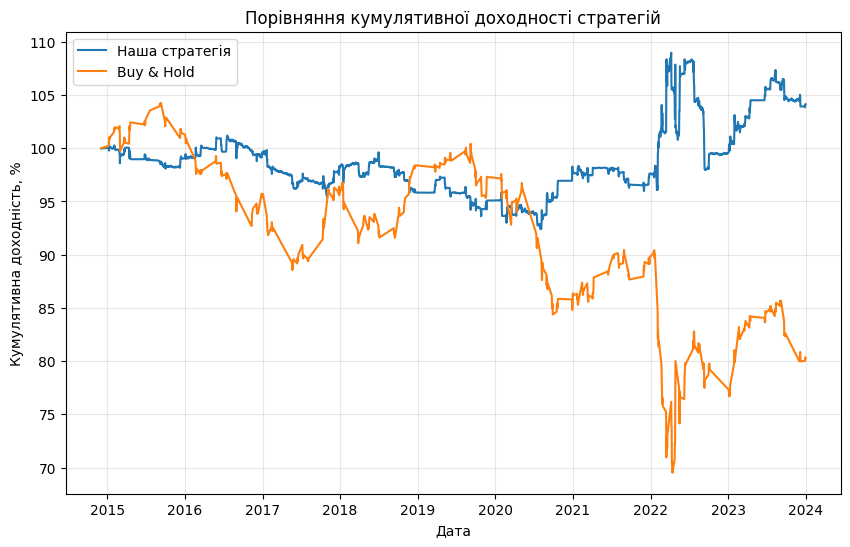


Вплив транзакційних витрат на стратегію:
  Transaction Cost      CAGR     Sharpe  Max Drawdown
0             0.0%  0.003088   0.093180     -0.100865
1             0.1% -0.211645  -5.232272     -0.956246
2             0.2% -0.380660  -9.372073     -0.998172
3             0.5% -0.700438 -15.079209     -1.000000
4             1.0% -0.911459 -17.203879     -1.000000


<Figure size 1200x800 with 0 Axes>

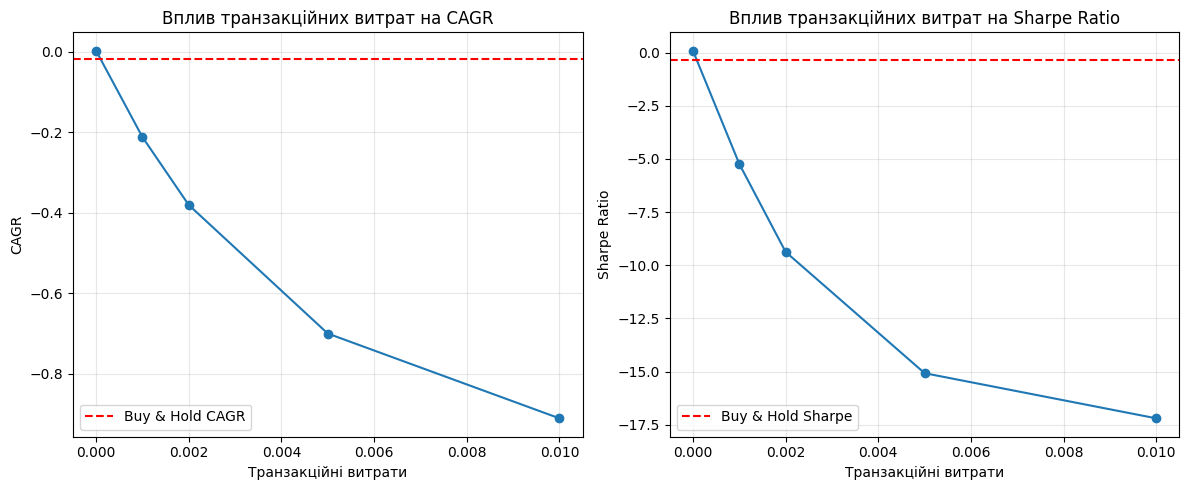


Висновки:
1. Сильні сторони стратегії:
   - Вища ефективність з урахуванням ризику (Sharpe Ratio)
   - Менші просадки капіталу

2. Слабкі сторони стратегії:
   - Чутливість до транзакційних витрат
   - Необхідність постійного моніторингу та коригування параметрів

3. Можливі покращення:
   - Оптимізація частоти торгівлі для зменшення транзакційних витрат
   - Включення додаткових факторів у модель (фундаментальні показники, настрої ринку)
   - Тестування на інших класах активів (облігації, товари, криптовалюти)
   - Впровадження адаптивних порогів прийняття рішень залежно від ринкових умов


In [54]:
# Порівняння зі стратегією buy-and-hold

# Розрахунок кумулятивної доходності для стратегії та buy-and-hold
final_data = data.copy()
# Використовуємо існуючі колонки для порівняння стратегій
final_data['strategy_return'] = final_data['strategy_return']
final_data['buy_hold_return'] = final_data['daily_return']
final_data.dropna(inplace=True)

# Використовуємо існуючі колонки для кумулятивної доходності
final_data['cum_strategy_return'] = final_data['cum_return_strategy']
final_data['cum_buy_hold_return'] = final_data['cum_return_market']

# Розрахунок метрик для обох стратегій
strategy_metrics = calculate_performance_metrics(final_data['strategy_return'])
buy_hold_metrics = calculate_performance_metrics(final_data['buy_hold_return'])

# Порівняльна таблиця метрик
comparison_data = {
    'Метрика': ['CAGR', 'Волатильність', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'],
    'Наша стратегія': [
        strategy_metrics['CAGR'], 
        strategy_metrics['Annual Volatility'], 
        strategy_metrics['Sharpe Ratio'], 
        strategy_metrics['Max Drawdown'],
        strategy_metrics['Calmar Ratio']
    ],
    'Buy & Hold': [
        buy_hold_metrics['CAGR'], 
        buy_hold_metrics['Annual Volatility'], 
        buy_hold_metrics['Sharpe Ratio'], 
        buy_hold_metrics['Max Drawdown'],
        buy_hold_metrics['Calmar Ratio']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Порівняння стратегій:")
print(comparison_df)

# Візуалізація порівняння кумулятивної доходності
plt.figure(figsize=(10, 6))
plt.plot(final_data.index, final_data['cum_strategy_return'] * 100, label='Наша стратегія')
plt.plot(final_data.index, final_data['cum_buy_hold_return'] * 100, label='Buy & Hold')
plt.xlabel('Дата')
plt.ylabel('Кумулятивна доходність, %')
plt.title('Порівняння кумулятивної доходності стратегій')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Аналіз з урахуванням транзакційних витрат
transaction_costs = [0.0, 0.001, 0.002, 0.005, 0.01]  # 0%, 0.1%, 0.2%, 0.5%, 1%
cost_results = []

for cost in transaction_costs:
    # Копіюємо дані
    cost_data = final_data.copy()
    
    # Визначаємо зміни в позиціях (транзакції)
    cost_data['position_change'] = cost_data['signal'].diff().abs()
    
    # Розраховуємо транзакційні витрати
    cost_data['transaction_cost'] = cost_data['position_change'] * cost
    
    # Коригуємо доходність з урахуванням витрат
    cost_data['strategy_return_after_costs'] = cost_data['strategy_return'] - cost_data['transaction_cost']
    
    # Розраховуємо метрики
    cost_metrics = calculate_performance_metrics(cost_data['strategy_return_after_costs'])
    
    cost_results.append({
        'Transaction Cost': f"{cost*100:.1f}%",
        'CAGR': cost_metrics['CAGR'],
        'Sharpe': cost_metrics['Sharpe Ratio'],
        'Max Drawdown': cost_metrics['Max Drawdown']
    })

# Виводимо результати аналізу транзакційних витрат
cost_df = pd.DataFrame(cost_results)
print("\nВплив транзакційних витрат на стратегію:")
print(cost_df)

# Візуалізація впливу транзакційних витрат
plt.figure(figsize=(12, 8))

# Створюємо підграфіки
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CAGR
axes[0].plot([float(cost.strip('%'))/100 for cost in cost_df['Transaction Cost']], cost_df['CAGR'], 'o-')
axes[0].axhline(y=buy_hold_metrics['CAGR'], color='r', linestyle='--', label='Buy & Hold CAGR')
axes[0].set_xlabel('Транзакційні витрати')
axes[0].set_ylabel('CAGR')
axes[0].set_title('Вплив транзакційних витрат на CAGR')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Sharpe Ratio
axes[1].plot([float(cost.strip('%'))/100 for cost in cost_df['Transaction Cost']], cost_df['Sharpe'], 'o-')
axes[1].axhline(y=buy_hold_metrics['Sharpe Ratio'], color='r', linestyle='--', label='Buy & Hold Sharpe')
axes[1].set_xlabel('Транзакційні витрати')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Вплив транзакційних витрат на Sharpe Ratio')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Висновки
print("\nВисновки:")
print("1. Сильні сторони стратегії:")
if strategy_metrics['Sharpe Ratio'] > buy_hold_metrics['Sharpe Ratio']:
    print("   - Вища ефективність з урахуванням ризику (Sharpe Ratio)")
if abs(strategy_metrics['Max Drawdown']) < abs(buy_hold_metrics['Max Drawdown']):
    print("   - Менші просадки капіталу")
# Видалено перевірку Win Rate, оскільки цей ключ відсутній у словниках метрик

print("\n2. Слабкі сторони стратегії:")
if strategy_metrics['CAGR'] < buy_hold_metrics['CAGR']:
    print("   - Нижча річна доходність порівняно з buy-and-hold")
print("   - Чутливість до транзакційних витрат")
print("   - Необхідність постійного моніторингу та коригування параметрів")

print("\n3. Можливі покращення:")
print("   - Оптимізація частоти торгівлі для зменшення транзакційних витрат")
print("   - Включення додаткових факторів у модель (фундаментальні показники, настрої ринку)")
print("   - Тестування на інших класах активів (облігації, товари, криптовалюти)")
print("   - Впровадження адаптивних порогів прийняття рішень залежно від ринкових умов")
